### Импортируем модули и библиотеки

In [55]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

import requests
from urllib.parse import urlencode

## Описываем задачи, которые нужно решить
В этом проекте есть три основные задачи:
1. Анализ покупок товаров
2. Когортный анализ retention
3. RFM-сегментация пользователей

**Теперь подробнее**
1. **Анализ покупок товаров** <br> 
Здесь нам нужно будет получить информацию о покупках пользователей в разных срезах: <br>
1.1 Сколько всего пользователей, которые совершили покупку только один раз? <br>
1.2 Сколько заказов в месяц в среднем не доставляется по разным причинам? Нужно вывести детализацию по причинам <br>
1.3 В какой день недели чаще всего покупается каждый товар? <br>
1.4 Сколько у каждого из пользователей в среднем покупок в неделю? Нужно сделать разбивку по месяцам <br> <br>
2. **Когортный анализ retention** <br>
Здесь нужно будет построить классическую когортную таблицу с метрикой retention. По нужно вычислить когорту с самым высоким retention на 3-й месяц. <br> <br>
3. **RFM-сегментация пользователей** <br>
Здесь нужно будет сегментировать клиентов по методу RFM (Recency, Frequency, Monetary). Границы сегментов нужно будет подобрать, исходя из особенностей сферы (e-commerce) и самих данных.


## Подгружаем данные

In [56]:
### Пишем функцию для загрузки файлов с Яндекс.Диска
def get_data_yadisk(yadisk_url, file_storage_path):
    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key = yadisk_url  # Сюда вписываете вашу ссылку

    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']

    # Загружаем файл и сохраняем его
    download_response = requests.get(download_url)
    dist_path = file_storage_path
    with open(dist_path, 'wb') as f:   # Здесь укажите нужный путь к файлу
        f.write(download_response.content)
    

### Скачиваем данные

In [57]:
# Прописываем URL для скачивания файлов
url_customers = 'https://disk.yandex.ru/d/QXrVDUoQvFhIcg'
url_orders = 'https://disk.yandex.ru/d/0zWmh1bYP6REbw'
url_order_items = 'https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg'

# Прописываем названия для файлов, в которые будут записываться загруженные таблицы
file_path_customers = 'customers.csv'
file_path_orders = 'orders.csv'
file_path_order_items = 'order_items.csv'

In [58]:
# Скачиваем .csv файл для таблицы customers
get_data_yadisk(url_customers,file_path_customers)

# Считываем загруженный .csv файл в dataframe
customers_table = pd.read_csv(file_path_customers)

# Проверяем, что таблица считалась корректно
customers_table.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [59]:
# Скачиваем .csv файл для таблицы customers
get_data_yadisk(url_orders,file_path_orders)

# Считываем загруженный .csv файл в dataframe
order_facts_table = pd.read_csv(file_path_orders, parse_dates=[
        "order_purchase_timestamp",
        "order_approved_at",
        "order_delivered_carrier_date", 
        "order_delivered_customer_date",
        "order_estimated_delivery_date",
    ])

# Проверяем, что таблица считалась корректно
order_facts_table.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [60]:
# Скачиваем .csv файл для таблицы customers
get_data_yadisk(url_order_items,file_path_order_items)

# Считываем загруженный .csv файл в dataframe
order_items_table = pd.read_csv(file_path_order_items, parse_dates = ['shipping_limit_date'])

# Проверяем, что таблица считалась корректно
order_items_table.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


## Проводим EDA 

### Изучаем таблицу order_facts_table
Еще раз опишем колонки в таблице и значения статусов заказов:

**Колонки в таблице order_facts_table и примечания по ним:** <br>
- order_id                      —  уникальный идентификатор заказа (номер чека) <br>
- customer_id                   —  позаказный идентификатор пользователя <br>
- По этому id нельзя считать пользователей, т.к. он не уникальный для каждого пользователя) <br>  
- order_status                  —  статус заказа <br>
- order_purchase_timestamp      —  время создания заказа <br>
- order_approved_at             —  время подтверждения оплаты заказа <br>
- order_delivered_carrier_date  —  время передачи заказа в логистическую службу <br>
- order_delivered_customer_date —  время доставки заказа <br> 
- order_estimated_delivery_date —  обещанная дата доставки <br>

Уникальные статусы заказов в таблице order_facts_table и примечания по ним: <br>
- created     —  создан <br>
- invoiced    —  выставлен счёт (и ожидается оплата по нему) <br>
- approved    —  подтверждён (подтверждена оплата) <br>
- processing  —  в процессе сборки заказа <br>
- shipped     —  отгружен со склада <br>
- delivered   —  доставлен пользователю <br>
- unavailable —  недоступен (заказ не выполнен самим магазином; возможно, по причине отсутствия товаров заказа на складе) <br>
- canceled    —  отменён пользователем <br>


In [61]:
# 1. Изучаем базовые характеристики и свойства 
# 1.1 Структура таблицы order_facts_table


order_facts_table.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [62]:
# 1.2 Типы переменных в таблице order_facts_table
order_facts_table.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [63]:
# 1.3 Изучаем период времени, который охватывает таблица

print(
    order_facts_table.order_purchase_timestamp.min()
)  # дата создания самого раннего заказа
print(
    order_facts_table.order_purchase_timestamp.max()
)  # дата создания самого позднего заказа


2016-09-04 21:15:19
2018-10-17 17:30:18


In [64]:
# 1.4 Изучаем кол-во заказов с разбивкой по годам и месяцам


orders_count_by_year = (
    order_facts_table.groupby([order_facts_table.order_purchase_timestamp.dt.year])
    .agg({"order_id": "count"})
    .reset_index()
    .rename(columns={"order_id": "orders_count", "order_purchase_timestamp": "year"})
)

orders_count_by_year


,year,orders_count
0,2016,329
1,2017,45101
2,2018,54011


In [65]:
# 1.5 Проверяем наличие дубликатов

# 1.5.1 Смотрим кол-во дублированных значений по колонкам, где их не должно быть.
# В этой таблице нас интересует только order_id

dup_values_count_by_column = order_facts_table['order_id'].duplicated()

dup_values_count_by_column.sum()

# Вывод: дубликатов order_id не найдено

np.int64(0)

In [66]:
# 1.6 Сравниваем заказы в order_facts_table и order_items_table

# 1.6.1
# Считаем кол-во уникальных order_id в order_facts_table и order_items_table и дискреп между ними


print(
    order_facts_table.order_id.nunique()
)  # кол-во уникальных order_id в order_facts_table
print(
    order_items_table.order_id.nunique()
)  # кол-во уникальных order_id в order_items_table
print(
    order_facts_table.order_id.nunique() - order_items_table.order_id.nunique()
)  # дискреп между двумя таблицами
print(
    (
        order_facts_table.order_id.nunique() - order_items_table.order_id.nunique()
    )  # % дискрепа от общего кол-ва уникальных order_id
    / order_items_table.order_id.nunique()
    * 100
)

order_facts_table.order_id.nunique() - order_items_table.order_id.nunique()

# Видим расхождение: 775 заказов присутствует в order_facts_table, но отсутствует в order_items_table

99441
98666
775
0.7854782802586504


775

In [67]:
# 1.6.2 Изучаем заказы, которые есть в order_facts_table, но нет в order_items_table


# 1.6.2.1 Делаем отдельную таблицу с теми заказами, которые есть в order_facts_table, но нет в order_items_table

orders_in_facts_but_not_in_items = order_facts_table[
    ~order_facts_table.order_id.isin(order_items_table.order_id)
]
orders_in_facts_but_not_in_items.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaT,NaT,2018-02-16
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaT,NaT,2017-09-05
737,d57e15fb07fd180f06ab3926b39edcd2,470b93b3f1cde85550fc74cd3a476c78,unavailable,2018-01-08 19:39:03,2018-01-09 07:26:08,NaT,NaT,2018-02-06
1130,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaT,NaT,NaT,2018-09-12


In [68]:
# 1.6.1.3 Изучаем композицию статусов заказов в таблице orders_in_facts_but_not_in_items


orders_in_facts_but_not_in_items.order_status.value_counts()

# Как видим, большинство заказов, которых нет в order_items_table, имеют статус unavailable

order_status
unavailable    603
canceled       164
created          5
invoiced         2
shipped          1
Name: count, dtype: int64

In [69]:
# 1.6.2 Сравниваем кол-во unavailable и cancelled заказов в таблицах order_facts и orders_in_facts_but_not_in_items

# Изучаем композицию статусов заказов в таблице order_facts_table
order_facts_table.order_status.value_counts()

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

**1.7 Изучаем, при каком статусе заказа заказ можно считать совершенной покупкой**

Совершенная покупка -- это оплаченный и не отмененный пользователем заказ <br>
Неотменённые заказы (во всяком случае, так должно быть) -- это все заказы без статуса canceled

С оплаченными заказами -- нужно подумать <br>
Столбец order_approved_at показывает время подтверждения оплаты заказа. <br>
Думаю, что если заказ не был оплачен, то у этого заказа в столбце order_approved_at будет пусто (null) <br>
У заказа, который всё еще не был оплачен, должен быть предыдущий статус, то есть 'created'

In [70]:
# 1.7.1
# Выводим таблицу с заказами со статусом "created"
orders_wo_approved_at_value = order_facts_table.query('order_status == "created"')

orders_wo_approved_at_value
# Действительно, видим, что при статусе "created" всё еще нет времени подтверждения оплаты заказа (order_approved_at)

# Получается, что совершенная покупка -- это заказ, который:
# - не имеет статус cancelled
# - имеет время подтверждения оплаты в столбце order_approved_at


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
7434,b5359909123fa03c50bdb0cfed07f098,438449d4af8980d107bf04571413a8e7,created,2017-12-05 01:07:52,NaT,NaT,NaT,2018-01-11
9238,dba5062fbda3af4fb6c33b1e040ca38f,964a6df3d9bdf60fe3e7b8bb69ed893a,created,2018-02-09 17:21:04,NaT,NaT,NaT,2018-03-07
21441,7a4df5d8cff4090e541401a20a22bb80,725e9c75605414b21fd8c8d5a1c2f1d6,created,2017-11-25 11:10:33,NaT,NaT,NaT,2017-12-12
55086,35de4050331c6c644cddc86f4f2d0d64,4ee64f4bfc542546f422da0aeb462853,created,2017-12-05 01:07:58,NaT,NaT,NaT,2018-01-08
58958,90ab3e7d52544ec7bc3363c82689965f,7d61b9f4f216052ba664f22e9c504ef1,created,2017-11-06 13:12:34,NaT,NaT,NaT,2017-12-01


In [71]:
# 1.7.2 Дополнительно смотрим, какие статусы есть у заказов, у которых не была подтверждена оплача
unpaid_orders = order_facts_table.query('order_approved_at.isna() == True')

unpaid_orders['order_status'].value_counts()



order_status
canceled     141
delivered     14
created        5
Name: count, dtype: int64

Видим, что у заказов, где не была подтверждена оплата, есть три статуса: canceled, created и delivered <br>
C canceled и created -- понятно. Canceled могли отменить до оплаты, по created оплата еще была подтверждена <br>
Странно то, что есть 14 delivered (доставленных) заказов, у которых оплата не была подтверждена <br>
Это могли быть бесплатные или какие-либо еще заказы, не требующие оплаты, но не имея доп. данных, лучше исключим эти заказы из дальнейшего анализа

In [72]:
# 1.8 Проверяем, есть ли заказы вообще без статуса

# 1.8.1 Выводим только строки с Null values в order_status  
test_orders_wo_status = (order_facts_table 
                        .query('order_status.isnull()') 
                        )

test_orders_wo_status

# На выходе получили пустой DataFrame. Это должно означать, что пустых значений в order_status нет


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date


In [73]:
# 1.8.2 На всякий случай проверяем наличие заказов без статуса другим способом

(order_facts_table['order_status'].value_counts().sum()) # Считаем сумму всех статусов в таблице

np.int64(99441)

In [74]:
# 1.8.3 Выводим общее кол-во строк в таблице
order_facts_table.shape 

# Как видим, общее кол-во строк со статусами равно общему кол-ву строк. 
# Вывод: заказов без статусов в таблице order_facts_table -- нет.

(99441, 8)

In [75]:
# 1.9 Изучаем, что значит статус заказа unavailable

# 1.9.1
# Выводим табличку с unavailable заказами 
unavailable_orders = (order_facts_table
                     .query('order_status == "unavailable"')
                     
                     )

unavailable_orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaT,NaT,2018-02-16
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaT,NaT,2017-09-05
737,d57e15fb07fd180f06ab3926b39edcd2,470b93b3f1cde85550fc74cd3a476c78,unavailable,2018-01-08 19:39:03,2018-01-09 07:26:08,NaT,NaT,2018-02-06
1160,2f634e2cebf8c0283e7ef0989f77d217,7353b0fb8e8d9675e3a704c60ca44ebe,unavailable,2017-09-27 20:55:33,2017-09-28 01:32:50,NaT,NaT,2017-10-27
...,...,...,...,...,...,...,...,...
99147,6cf5c427fb11bc5fe8abefa86aa7ba0b,91ac14a1e50bc022eeecf0c2ba37006a,unavailable,2017-10-17 10:53:48,2017-10-19 03:12:43,NaT,NaT,2017-10-27
99233,1c7c8ab324927f5b6e52338bd110bef4,95b1767df51d6fa09402267d8de314df,unavailable,2017-12-23 18:48:09,2017-12-23 18:54:22,NaT,NaT,2018-01-19
99252,aaab15da689073f8f9aa978a390a69d1,df20748206e4b865b2f14a5eabbfcf34,unavailable,2018-01-16 14:27:59,2018-01-17 03:37:34,NaT,NaT,2018-02-06
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaT,NaT,2017-09-15


In [76]:
# 1.9.2
# Смотрим иформацию по unavailable заказах в таблице order_items_table

unavailable_orders_items = order_items_table[order_items_table['order_id'].isin(unavailable_orders['order_id'])]

unavailable_orders_items
# Видим, что только у 7 из 609 unavailable заказов есть информация о товарах в них

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
11558,1a47da1d66c70489c8e35fe2b5433ab7,1,eba7488e1c67729f045ab43fac426f2e,620c87c171fb2a6dd6e8bb4dec959fc6,2016-10-11 18:53:48,249.90,20.85
20902,2fd1c83dd4714cf3cf796fffb6c8de62,1,17c7ec33a1657924ad493e6978b4bf91,3d01d1c414c44b5943a09619ff3853cb,2016-10-10 15:55:42,99.00,9.12
20903,2fd1c83dd4714cf3cf796fffb6c8de62,2,966a067b38634929844120e39b1576bc,61f159ef6da2d441951d2c0efa719362,2016-10-10 15:55:41,59.99,24.08
26470,3c3ca08854ca922fe8e9cedfd6841c8a,1,ac6c24af9f913c9375a3ea77883bda6e,5206cc4bc2297c833e6061c49bf9c43f,2016-10-12 13:21:35,35.00,10.96
34411,4dd47e84e6b8ff4a63d0b8425e6d788e,1,2aa489c905e1d41d8c716a6d6912d8c2,620c87c171fb2a6dd6e8bb4dec959fc6,2016-10-11 01:09:09,299.90,13.68
37340,54bb06e1ca86bd99ee2a8d6288bf4ede,1,bef13288a0f8b26d763411ced1dfa268,cf281cf8b7affbdfe751b29cc85580e1,2016-10-29 09:43:46,64.90,25.33
97008,dc18a044b56ed174037ca164cdf2e921,1,faa268ecc8a8434cb4ebee091b3222d6,f0563bacf40c311f1c4d3d6b67b8a7a7,2016-10-21 16:18:52,1199.00,28.78


In [77]:
# 1.9.3 
# Изучаем, у скольки unavailable заказов есть время: 
# - создания заказа 
# - подтверджения оплаты 
# - передачи курьеру
# - фактивческой доставки
# - ожидаемой доставки

unavaiable_order_statuses_time_check = unavailable_orders[['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date']].notna().sum()

unavaiable_order_statuses_time_check



order_purchase_timestamp         609
order_approved_at                609
order_delivered_carrier_date       0
order_delivered_customer_date      0
order_estimated_delivery_date    609
dtype: int64

**Видим, что:**
1. 0 unavailable заказов были переданы в службу логистики, судя по нулю non-null значений в order_delivered_carrier_date
2. 0 unavailable заказов были доставлены, при этом всем заказам назначилась ожидаемая дата доставки

Если сконструировать цепочку событий по этим данным, то в случае unavailable заказов :
1. Сделал заказ
2. Оплатил его
3. Не отменил его, то есть сохранил изначальное намерение о покупке, а значит заказал не по ошибке.
4. Получил ожидаемую дату доставки 
5. По какой-то причине заказ даже не был передан в службу доставки

**Вывод такой:**
Unavailable заказы не передаются в логистику и не доставляются, потому что есть какая-то проблема 
с выполнением этого заказ на стороне магазина. Например, все товары в заказе отсутствуют на складе.
Что это значит для анализа:
1. Unavailable заказы нельзя использовать для анализа любых метрик, связанных с деньгами и товарами,
т.к в них почти всегда отсутствует информация от товарах в таблице order_items_table
2. Однако, unavailable заказы можно использовать в анализе пользовательского поведения,
без привязки к деньгам или товарам, т.к статус unavailable все еще не отменяет намерение пользователя совершить заказ

In [78]:
# 1.10 Изучаем, все ли неотмененные оплаченные заказы есть в таблице order_items_table

# 1.10.1 
# Делаем таблицу с неотмененными оплаченными заказами

paid_non_canceled_orders = order_facts_table.query( 
    'order_approved_at.isna() == False & order_status != "canceled"' # неотменненые заказы, у которых в колонке order_approved_at не null значения 
).copy() # делаем эту таблицу как копию, чтобы избежать конфликтов в будущем

paid_non_canceled_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [79]:
# 1.10.2 Делаем таблицу с неотмененными оплаченными заказами, которых нет order_items_table

non_cancelled_paid_orders_not_in_items_table = paid_non_canceled_orders[
    ~paid_non_canceled_orders['order_id'].isin(order_items_table['order_id'])
]

# 1.10.3 Смотрим кол-во уникальных заказов в этой табличке
non_cancelled_paid_orders_not_in_items_table['order_id'].nunique()

606

In [80]:
# 1.10.4 Изучаем композицию статусов среди неотмененных оплаченных заказов, которых нет в таблице order_items_table
non_cancelled_paid_orders_not_in_items_table['order_status'].value_counts()



order_status
unavailable    603
invoiced         2
shipped          1
Name: count, dtype: int64

**Вывод:** <br>
Почти все из них имеют статус unavailable<br>
В таблице order_items_table есть почти все неотмененные оплаченные заказы, кроме:
большинства unavailable заказов -- 

- С unavailable заказами понятно. У почти всех unavailable заказов нет товаров -- они и не должны бать в order_items_table 
- Парочка заказов Invoice и Shipped -- непонятно, почему их нет в order_items_table. Но их настолько мало, 
что не вижу смысла разбираться в этом отдельно. Должно быть, какая-то техническая ошибка

1.11 Пытаемся понять, что какой статус идет раньше: approved или invoiced

У нас есть два статуса заказа: 
- approved -- подтверджен (сам заказ или его оплата -- пока непонятно)
- invoiced -- выставлен счёт

По логике, сначала за заказ выставляется счет, потом он оплачивается и подтверждается его оплата.
Но в списке статусов approved стоит перед invoiced

Пытаемся понять, как эти статусы соотносятся друг с другом


In [81]:
# 1.11.1 Делаем табличку с заказами approved и invoiced

invoiced_and_approved_orders = (order_facts_table.query('order_status.isin(["approved","invoiced"])'))

invoiced_and_approved_orders.sort_values(['order_status','order_purchase_timestamp']).head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
44897,a2e4c44360b4a57bdff22f3a4630c173,8886130db0ea6e9e70ba0b03d7c0d286,approved,2017-02-06 20:18:17,2017-02-06 20:30:19,NaT,NaT,2017-03-01
88457,132f1e724165a07f6362532bfb97486e,b2191912d8ad6eac2e4dc3b6e1459515,approved,2017-04-25 01:25:34,2017-04-30 20:32:41,NaT,NaT,2017-05-22
78824,dd359d3c294458c6d642b2eea9212bf5,5c58d1ea5a893380ecdd96dd6dfd5ec5,invoiced,2016-10-04 13:02:10,2016-10-05 03:08:27,NaT,NaT,2016-11-24
24222,711b9be9c346d9ecdb9d38a5e1e7e39b,81e4aed5ab4253757305267b80712689,invoiced,2016-10-04 13:38:37,2016-10-04 14:08:38,NaT,NaT,2016-11-24
32817,a6475bb7a50387e3c665534e15bd40ac,442d66f0d96f656096dd70f1b0391e40,invoiced,2016-10-04 16:28:25,2016-10-05 02:46:17,NaT,NaT,2016-11-28


In [82]:
# 1.11.2 Смотрим соотношение approved и invoiced заказов
invoiced_vs_approved_composition = invoiced_and_approved_orders['order_status'].value_counts()

# Как видим, есть 314 invoiced заказов и всего 2 approved

1.11.3 Делаем вывод, что сначала идет статус invoiced, и уже потом -- approved

К этому выводу есть два аргумента:

- Сама логика покупки в любом интернет-магазине предполагает, что сначала выставляется счет за товары, 
который нужно оплатить. <br> Дальше заказ принимается на стороне магазине и начинается процесс его сборки и отправки

- Заказов со статусом invoiced гораздо больше, чем approved. Предлагаю рассматривать эти статусы <br>
как финальные статусы заказа, на которых эти заказы "застряли". Тогда у нас есть две версии:

1. Сначала invoiced, потом approved. То есть, сначала за заказ отправляется счёт, потом его оплата подтверждается. <br>
Тогда у нас 314 заказов, которые не получили оплату и застряли. И 2 заказа, которые получили оплату <br>
и застряли на следующем этапе

2. Наоборот: сначала approved, потому invoiced. Тогда у нас 2 неоплаченных заказа, и 314 заказов,  <br>
которые были оплачены и застряли на следующем этапе -- то есть, так и не были взяты в работу (processing) после оплаты <br>

Первая версия выглядит более убедительной. Не получить оплату за заказы и оставить его на этапе invoiced 
-- более вероятно, чем получить её и просто не стать собирать заказ.

In [83]:
# 1.12 Проверяем наличие пропущенных значений

# 1.12.1 Выводим кол-во null-значений во всех колонках

null_value_counts = order_facts_table.isna().sum()

null_value_counts




order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Видим, что null-значения есть только в колонках со статусом заказа <br>
Они и должны быть там, если у заказа не был достигнут статус, обозначенный в соответствующей колонке

In [84]:
# 1.12.2 Изучаем, есть ли у заказов с определенными статусами время получения этого статуса

# 1.12.2.1 Проверяем, есть ли у всех approved заказов время в колонке order_approved_at


approved_orders = order_facts_table.query('order_status == "approved"')

approved_orders["order_approved_at"].isna().sum()


np.int64(0)

In [85]:
# 1.12.2.2 Проверяем,у каких заказов нет времени аппрува


orders_wo_approval_time = order_facts_table.query("order_approved_at.isna() == True")

orders_wo_approval_time["order_status"].value_counts()



order_status
canceled     141
delivered     14
created        5
Name: count, dtype: int64

Видим, среди заказов без времени подтверждения, есть:
- created -- логично, ведь эти заказы остались в статусе "создан"
- canceled -- вполне ок, если это заказы, которые были отменены до оплаты
- delivered -- это вряд ли ок; заказ должен быть оплачен, чтобы быть доставленым

In [86]:
# 1.12.2.3 Смотрим доставленные заказы без подтверждения оплаты

orders_wo_approval_time.query('order_status == "delivered"')




,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
5323,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17
16567,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21
19031,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17
22663,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31
23156,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20
26800,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,delivered,2017-01-19 12:48:08,NaT,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01
38290,d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,delivered,2017-02-19 01:28:47,NaT,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27
39334,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,delivered,2017-02-18 11:04:19,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22
48401,7002a78c79c519ac54022d4f8a65e6e8,d5de688c321096d15508faae67a27051,delivered,2017-01-19 22:26:59,NaT,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16
61743,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17 17:21:55,NaT,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20



**Вывод:**

Наблюдения по этим заказам:
1. У всех них есть времена дальнейших этапов: передачи в логистику и доставки клиенту
2. Все они созданы в январе-феврале 2017 года

Выглядит так, что заказы корректные, просто по ним не была подтверждена оплата. Возможно, это был технический сбой. <br>
Также возможно, что была акция на бесплатные товары -- поэтому за них не нужно платить. <br>
В любом случае, не будем исключать эти заказы из анализа <br>

In [87]:
# 1.12.2.4 Смотрим, у каких заказов нет времени передачи в службу доставки

# Смотрим композицию статусов у заказов без времени передачи в службу логистики
orders_wo_order_delivered_carrier_date = order_facts_table.query('order_delivered_carrier_date.isna() == True')

orders_wo_order_delivered_carrier_date['order_status'].value_counts()

# Здесь окей видеть все статусы, кроме delivered
# Заказ не может быть доставлен, если он не передан в логистику

order_status
unavailable    609
canceled       550
invoiced       314
processing     301
created          5
approved         2
delivered        2
Name: count, dtype: int64

In [88]:
# Смотрим "доставленные" заказы, которые не были переданы в логистику

orders_wo_order_delivered_carrier_date.query('order_status == "delivered"')



,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
73222,2aa91108853cecb43c84a5dc5b277475,afeb16c7f46396c0ed54acb45ccaaa40,delivered,2017-09-29 08:52:58,2017-09-29 09:07:16,NaT,2017-11-20 19:44:47,2017-11-14
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23


Похоже, произошел технический сбой, и либо проставился статус delivered у недоставленного заказа, 
либо не проставилось время доставки у доставленного.

Учитывая кол-во таких заказов (всего 2 на все ~100 тысяч), не будем придавать этому большого значения
При определении доставленных заказов будем брать два условия: статус delivered и наличие времени доставки

In [89]:
# 1.12.2.5 Смотрим, у каких заказов нет времени фактической доставки клиенту

orders_wo_order_delivered_customer_date = order_facts_table.query('order_delivered_customer_date.isna() == True')

orders_wo_order_delivered_customer_date['order_status'].value_counts()

order_status
shipped        1107
canceled        619
unavailable     609
invoiced        314
processing      301
delivered         8
created           5
approved          2
Name: count, dtype: int64

In [90]:
# 1.12.2.6 Смотрим "доставленные" заказы без времени доставки

orders_wo_order_delivered_customer_date.query('order_status == "delivered"')

# Вывод:
# Действительно доставленными заказами будем считать только те, у которых выполняются два условия:
# - status 'delivered'
# - есть время фактической доставки в колонке order_delivered_customer_date

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaT,2017-12-18
20618,f5dd62b788049ad9fc0526e3ad11a097,5e89028e024b381dc84a13a3570decb4,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaT,2018-07-16
43834,2ebdfc4f15f23b91474edf87475f108e,29f0540231702fda0cfdee0a310f11aa,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaT,2018-07-30
79263,e69f75a717d64fc5ecdfae42b2e8e086,cfda40ca8dd0a5d486a9635b611b398a,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,NaT,2018-07-30
82868,0d3268bad9b086af767785e3f0fc0133,4f1d63d35fb7c8999853b2699f5c7649,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaT,2018-07-24
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23
97647,ab7c89dc1bf4a1ead9d6ec1ec8968a84,dd1b84a7286eb4524d52af4256c0ba24,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaT,2018-06-26
98038,20edc82cf5400ce95e1afacc25798b31,28c37425f1127d887d7337f284080a0f,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaT,2018-07-19


### **Наблюдения по таблице order_fact_table, замеченные в процессе EDA:**

**1. Общее описание таблицы**<br>
Это не совсем таблица фактов, а скорее таблица-снэпшот информации о заказах на определенный момент времени. <br>
У каждого заказа только один статус -- последний известный <br>

2. **Что считаем успешной покупкой**<br>
**Коротко:** <br> 
Все товары, у которых есть время в столбце order_approved_at, кроме:<br>
- заказов со статусом canceled<br>
- большинства заказов со статусом unavailable<br>

**Подробнее:** <br>
В столбце order_approved_at указывается время подтверждения оплаты. <br>
Оно появляется при статусе approved (его ещё нет на момент статуса created)<br>

Допустим, мы рассматриваем совершенную покупку как действие, которое совершает пользователь на своей стороне вне зависимости от действий магазина. <br> 
Тогда будем считать как совершённую покупку любой заказ, у которого есть время в order_approved_at, кроме cancelled и unavaiable заказов. <br>

Почему не считаем Canceled и Unavailable заказы успешной покупкой: <br>
- Canceled заказы не считаем успешной покупкой, так как пользователь отозвал свое решение о покупке, и деньги за этот заказ мы не получим.

- Unavailable заказы считаем успешной покупкой только в случае, если интересует сам факт покупки, без данных по товарам. 
Всего есть 609 unavailable заказов, из которых лишь у семи указаны товары, входящие в заказ.
Если анализ касается данных о товарах и выручке с заказа, то в нем мы не будем считать Unavailable заказы без данных
о товарах -- просто потому что мы не можем анализировать данные о товарах, которых нет.

3. **Есть доставленные заказы без времени доставки**<br>
По какой-то причине есть 8 заказов со статусом delivered, но без времени доставки. Нужно изучить, почему так

4. **Вопрос: есть ли заказы, которые доставляются слишком долго, но не уходят в unavailable/canceled**<br>
Нужно изучить, есть ли заказы с неприлично долгим сроком доставки, которые при этом не ушли в статус unavailable
Смысл ресерча -- выделить и материализовать неявный статус "delivery_too_long". 
Это когда заказ доставляется, но настолько долго, что его можно считать недоставленным


### **Результаты проверки на аномалии и базовые ошибки:**
1. **Дубликаты -- отсутствуют -- проверено по order_id**
2. **Разница числа заказов между -- ПРИСУТСТВУЕТ!**<br>
В order_items_table уникальных заказов меньше, чем в order_facts_table. 
Так должно быть или какие-то заказы потерялись -- нужно выяснить
Нужно изучить, какие заказы есть в order_facts_table, но нет в order_items_table. Их статус, время доставки и т.д

Результаты проверки кол-ва уникальных заказов в двух таблицах:<br>
order_facts_table.order_id.nunique() == 99441<br>
order_items_table.order_id.nunique() == 98666<br>
Разница между двумя таблицами -- 775 уникальных заказов в пользу order_facts_table<br>
Разница составляет ~0.79% от общего числа заказов<br>




### Изучаем таблицу order_items_table

**Описание колонок order_facts_table:**
- order_id             —  уникальный идентификатор заказа (номер чека)
- order_item_id        —  идентификатор товара внутри одного заказа
- product_id           —  ид товара (аналог штрихкода)
- seller_id            — ид производителя товара
- shipping_limit_date  —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
- price                —  цена за единицу товара
- freight_value        —  вес товара

— Пример структуры данных можно визуализировать по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5

Наблюдения по таблицу order_items_table:
1. В таблице есть заказы со статусом unavailable, и в них есть товары. Таких заказов всего 6 из около 600 всех unavailable.
Это наталкивает на мысль, что под unavailable может иметься в виду разные статусы

In [91]:
# Проводим EDA
# 2.1 Изучаем структуру данных таблицы на примере одного заказа

order_items_table.query('order_id == "00143d0f86d6fbd9f9b38ab440ac16f5"')


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1


In [92]:
# 2.2 Смотрим кол-во уникальных товаров по product_id
order_items_table.product_id.nunique()

32951

In [93]:
# 2.3 Смотрим, есть ли unavailable заказы в таблице order_items_table

# 2.3.1 Выделяем unavailable заказы в отдельную таблицу

unavaiable_orders_data = order_facts_table.query('order_status == "unavailable"')

unavaiable_orders_data.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaT,NaT,2018-02-16
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaT,NaT,2017-09-05
737,d57e15fb07fd180f06ab3926b39edcd2,470b93b3f1cde85550fc74cd3a476c78,unavailable,2018-01-08 19:39:03,2018-01-09 07:26:08,NaT,NaT,2018-02-06
1160,2f634e2cebf8c0283e7ef0989f77d217,7353b0fb8e8d9675e3a704c60ca44ebe,unavailable,2017-09-27 20:55:33,2017-09-28 01:32:50,NaT,NaT,2017-10-27


In [94]:
# 2.3.2 Ищем в таблице order_items_table unavailable заказы и выводим в отдельную таблицу

unavailable_orders_w_items = order_items_table[
    order_items_table.order_id.isin(unavaiable_orders_data.order_id)
].sort_values(["order_id"], ascending=True)

unavailable_orders_w_items.head(10)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
11558,1a47da1d66c70489c8e35fe2b5433ab7,1,eba7488e1c67729f045ab43fac426f2e,620c87c171fb2a6dd6e8bb4dec959fc6,2016-10-11 18:53:48,249.90,20.85
20902,2fd1c83dd4714cf3cf796fffb6c8de62,1,17c7ec33a1657924ad493e6978b4bf91,3d01d1c414c44b5943a09619ff3853cb,2016-10-10 15:55:42,99.00,9.12
20903,2fd1c83dd4714cf3cf796fffb6c8de62,2,966a067b38634929844120e39b1576bc,61f159ef6da2d441951d2c0efa719362,2016-10-10 15:55:41,59.99,24.08
26470,3c3ca08854ca922fe8e9cedfd6841c8a,1,ac6c24af9f913c9375a3ea77883bda6e,5206cc4bc2297c833e6061c49bf9c43f,2016-10-12 13:21:35,35.00,10.96
34411,4dd47e84e6b8ff4a63d0b8425e6d788e,1,2aa489c905e1d41d8c716a6d6912d8c2,620c87c171fb2a6dd6e8bb4dec959fc6,2016-10-11 01:09:09,299.90,13.68
37340,54bb06e1ca86bd99ee2a8d6288bf4ede,1,bef13288a0f8b26d763411ced1dfa268,cf281cf8b7affbdfe751b29cc85580e1,2016-10-29 09:43:46,64.90,25.33
97008,dc18a044b56ed174037ca164cdf2e921,1,faa268ecc8a8434cb4ebee091b3222d6,f0563bacf40c311f1c4d3d6b67b8a7a7,2016-10-21 16:18:52,1199.00,28.78


In [95]:
# 2.3.3 Смотрим кол-во уникальных unavailable заказов в таблице order_items_table
unavailable_orders_w_items.order_id.nunique()


6

Вывод:
В таблице order_items_table есть unavailable заказы, их 6 штук

2.4 Пытаемся понять, как колонка shipping_limit_date встраивается в общую воронку дат статусов

Делаем таблицу с недоставленными заказами по нашим критериям.
У таких заказов:
- один из статусов: approved, processing, shipped, unavailable, canceled
- есть время подтверждения оплаты заказа в колонке order_approved_at
- может быть или не быть время передачи в службу логистики в колонке order_delivered_carrier_date -- зависит от статуса
- нет времени фактической доставки в колонке order_delivered_customer_date

In [96]:
# Создаем таблицу с недоставленными заказами non_delivered_orders и джоиним в нее колонку shipping_limit_date

non_delivered_orders = order_facts_table.query( 
    # берем только заказы со статусами approved, processing, shipped, unavailable, canceled
    'order_status.isin(["approved","processing","shipped","unavailable","canceled"]) & '
    'order_approved_at.isna() == False & ' # есть время подтверждения оплаты заказа, то есть заказ оплачен
    'order_delivered_customer_date.isna() == True' # нет времени фактической доставки, то есть заказ не доставлен
) 

non_delivered_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07
162,36530871a5e80138db53bcfd8a104d90,4dafe3c841d2d6cc8a8b6d25b35704b9,shipped,2017-05-09 11:48:37,2017-05-11 11:45:14,2017-05-11 13:21:47,NaT,2017-06-08
231,4d630f57194f5aba1a3d12ce23e71cd9,6d491c9fe2f04f6e2af6ec033cd8907c,shipped,2017-11-17 19:53:21,2017-11-18 19:50:31,2017-11-22 17:28:34,NaT,2017-12-13


In [97]:
 # 2.4.1 Делаем сабсет с order_id и shipping_limit_date по каждому заказу из таблицы order_items_table

orders_shipping_limit_dates = order_items_table[["order_id", "shipping_limit_date"]]

orders_shipping_limit_dates.head()


,order_id,shipping_limit_date
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-19 09:45:35
1,00018f77f2f0320c557190d7a144bdd3,2017-05-03 11:05:13
2,000229ec398224ef6ca0657da4fc703e,2018-01-18 14:48:30
3,00024acbcdf0a6daa1e931b038114c75,2018-08-15 10:10:18
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-13 13:57:51


In [98]:
# 2.4.2 Джоиним колонку shipping_limit_date к таблице с недоставленными заказами

non_delivered_orders_w_shipping_limit_dates = non_delivered_orders.merge(
    right=orders_shipping_limit_dates, how="left", on="order_id"
)

non_delivered_orders_w_shipping_limit_dates.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date
0,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28,2018-06-13 04:30:33
1,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03,2017-09-20 14:30:09
2,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07,2018-01-18 02:32:30
3,36530871a5e80138db53bcfd8a104d90,4dafe3c841d2d6cc8a8b6d25b35704b9,shipped,2017-05-09 11:48:37,2017-05-11 11:45:14,2017-05-11 13:21:47,NaT,2017-06-08,2017-05-17 11:45:14
4,4d630f57194f5aba1a3d12ce23e71cd9,6d491c9fe2f04f6e2af6ec033cd8907c,shipped,2017-11-17 19:53:21,2017-11-18 19:50:31,2017-11-22 17:28:34,NaT,2017-12-13,2017-11-23 19:50:31


In [99]:
# 2.4.3 Смотрим, у каких заказов вообще появляется эта shipping_limit_date, чтобы правильнее понять процесс

orders_w_present_sld = (
    non_delivered_orders_w_shipping_limit_dates
    .query("shipping_limit_date.isna() == False")["order_status"]
    .value_counts()
    .reset_index()
)

orders_w_present_sld


,order_status,count
0,shipped,1185
1,canceled,535
2,processing,357
3,unavailable,7
4,approved,3


In [100]:
# 2.4.4 Теперь смотрим, у каких заказов колонка shipping_limit_date НЕ появляется


orders_wo_present_sld = (
    non_delivered_orders_w_shipping_limit_dates
    .query("shipping_limit_date.isna() == True")["order_status"]
    .value_counts()
    .reset_index()
)

orders_wo_present_sld


,order_status,count
0,unavailable,603
1,canceled,23
2,shipped,1


In [101]:
# 2.4.5 Сравниваем заказы, где есть shipping_limit_date, и где её нет

# 2.4.5.1 Делаем табличку для сравнения


orders_w_vs_wo_sld_comparison = pd.merge(
    left=orders_w_present_sld,
    right=orders_wo_present_sld,
    on="order_status",
    how="outer",  # outer join, чтобы получить все статусы в обоих таблицах вне зависимости от наличия shipping_limit_date
).fillna(0)  # заполняем null значения нулями

orders_w_vs_wo_sld_comparison


,order_status,count_x,count_y
0,approved,3,0.0
1,canceled,535,23.0
2,processing,357,0.0
3,shipped,1185,1.0
4,unavailable,7,603.0


In [102]:
# 2.4.5.2 Сортируем получившуюся таблицу в соответствие с этапами заказа

# Создаем лист с порядком статусов

specific_order = [
    "created",
    "invoiced",
    "approved",
    "processing",
    "shipped",
    "delivered",
    "canceled",
    "unavailable",
]

# 2.4.5.3 Переводим столбец со статусом заказа в типа данных Categorical, категории указываем из созданного списка статусов

orders_w_vs_wo_sld_comparison["order_status"] = pd.Categorical(
    orders_w_vs_wo_sld_comparison["order_status"],
    categories=specific_order,
    ordered=True,
)

# 2.4.5.4 Сортируем таблицу по модифицированному столбцу order_status, где теперь настроен корректный порядок статусов

orders_w_vs_wo_sld_comparison = orders_w_vs_wo_sld_comparison.sort_values(
    "order_status"
)


In [103]:
orders_w_vs_wo_sld_comparison


,order_status,count_x,count_y
0,approved,3,0.0
2,processing,357,0.0
3,shipped,1185,1.0
1,canceled,535,23.0
4,unavailable,7,603.0


Замечаем пару моментов: <br>
- shipping_limit_date появляется на моменте выставления счета (почти всегда) <br>
- у unavailable заказов этой даты нет (почти всегда); похоже, потому что заказ при этом статусе и не должен доставляться

In [104]:
# 2.4.6 Изучаем, как дата в shipping_limit_date соотносится с другими датами статусов в заказах с различными статусами

# shipping_limit_date становится актуальной только после сборки заказа. 
# Значит, все статусы заказа до processing нас здесь не инетресуют

# 2.4.6.1 Выделяем из таблицы non_delivered_orders_w_shipping_limit_dates только те столбцы, которые нужны
orders_w_sld_sample = non_delivered_orders_w_shipping_limit_dates[
    [
        "order_id",
        "order_status",
        "order_purchase_timestamp",
        "order_approved_at",
        "order_delivered_carrier_date",
        "order_estimated_delivery_date",
        "order_delivered_customer_date",
        "shipping_limit_date"
    ]
]


In [105]:
# 2.4.6.2 Изучаем shipping_limit_date у shipped заказов


shipped_orders_w_sld_sample = orders_w_sld_sample.query('order_status == "shipped"')

shipped_orders_w_sld_sample.query('order_status == "shipped"').head()


,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_estimated_delivery_date,order_delivered_customer_date,shipping_limit_date
0,ee64d42b8cf066f35eac1cf57de1aa85,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,2018-06-28,NaT,2018-06-13 04:30:33
2,6942b8da583c2f9957e990d028607019,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,2018-02-07,NaT,2018-01-18 02:32:30
3,36530871a5e80138db53bcfd8a104d90,shipped,2017-05-09 11:48:37,2017-05-11 11:45:14,2017-05-11 13:21:47,2017-06-08,NaT,2017-05-17 11:45:14
4,4d630f57194f5aba1a3d12ce23e71cd9,shipped,2017-11-17 19:53:21,2017-11-18 19:50:31,2017-11-22 17:28:34,2017-12-13,NaT,2017-11-23 19:50:31
6,3b4ad687e7e5190db827e1ae5a8989dd,shipped,2018-06-28 12:52:15,2018-06-28 13:11:09,2018-07-04 15:20:00,2018-08-03,NaT,2018-07-04 13:11:09


In [106]:
# Сразу видим пример заказа, который был доставлен в логистическую службу после максимальной даты (shipping_limit_date)

# 2.4.6.3 Выводим пример такого заказа (order_id = 6147a4d49752afd35a119d794e481588)


shipped_orders_w_sld_sample.query('order_id == "6147a4d49752afd35a119d794e481588"')


,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_estimated_delivery_date,order_delivered_customer_date,shipping_limit_date
12,6147a4d49752afd35a119d794e481588,shipped,2017-04-25 13:35:09,2017-04-25 13:45:16,2017-05-02 15:29:33,2017-05-29,NaT,2017-05-02 13:45:16


In [107]:
# 2.4.6.4 Ищем другие заказы, которые были отправлены после даты в shipping_limit_date

# По логике, такие заказы были отправлены (если вообще отправлены) ПОСЛЕ лимита даты для передачу в логистическую службу.
# Иными словами, продавец должен был прислать заказ в логистическую службу до определенной даты, но не успел.
# Тогда, предполагаем, эти заказы отправляются в следующую "итерацию" доставок,
# и соответственно, должны не успевать к обещанному времени доставки (order_estimated_delivery_date)


orders_shipped_after_sld = (
    orders_w_sld_sample[
        orders_w_sld_sample["order_delivered_carrier_date"]
        > orders_w_sld_sample["shipping_limit_date"]
    ]
).copy()


In [108]:
# 2.4.6.5 Смотрим на общее кол-во таких заказов, доставленных после sld и их статусы


orders_shipped_after_sld["order_status"].value_counts()

# Как видим, большинство таких заказов со статусом shipped
# Наличие сanceled заказов не вызывают противоречий: их могли отменить уже в пути


order_status
shipped     143
canceled      8
Name: count, dtype: int64

In [109]:
orders_shipped_after_sld.head()

,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_estimated_delivery_date,order_delivered_customer_date,shipping_limit_date
6,3b4ad687e7e5190db827e1ae5a8989dd,shipped,2018-06-28 12:52:15,2018-06-28 13:11:09,2018-07-04 15:20:00,2018-08-03,NaT,2018-07-04 13:11:09
12,6147a4d49752afd35a119d794e481588,shipped,2017-04-25 13:35:09,2017-04-25 13:45:16,2017-05-02 15:29:33,2017-05-29,NaT,2017-05-02 13:45:16
22,c5e1ff5a434a0e128ac186bd92c1060d,shipped,2018-03-10 13:39:36,2018-03-10 13:50:29,2018-03-21 19:18:22,2018-04-06,NaT,2018-03-21 13:50:29
31,362cc20bf09835f4398cedd319fb7d8e,shipped,2018-03-27 12:10:05,2018-03-29 03:28:46,2018-04-04 19:08:37,2018-04-19,NaT,2018-04-04 03:28:46
41,1488ee1c0dc7439e64d5df80ae9f6089,shipped,2018-03-16 17:44:05,2018-03-16 17:55:36,2018-03-22 20:33:27,2018-04-13,NaT,2018-03-22 17:55:36


In [110]:
orders_shipped_after_sld.dtypes

order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
order_delivered_customer_date    datetime64[ns]
shipping_limit_date              datetime64[ns]
dtype: object

In [111]:
# 2.4.7 Изучаем, на какое время продавцы опаздывают с доставкой товара до логистической службы

# 2.4.7.1 Добавляем колонку с временным интервалом между shipping_limit_date и фактическим временем передачи в логистику

orders_shipped_after_sld["delivered_carrier_time_due"] = (
    orders_shipped_after_sld["order_delivered_carrier_date"]
    - orders_shipped_after_sld["shipping_limit_date"]
)


In [112]:
# 2.4.7.2 Смотрим максимальное кол-во времени, на которое продавцы опаздывали с доставкой товара для передачи в логистику

orders_shipped_after_sld.sort_values(
    "delivered_carrier_time_due", ascending=False
).head()


,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_estimated_delivery_date,order_delivered_customer_date,shipping_limit_date,delivered_carrier_time_due
590,38541d08d4eb7d571b5b80cb6ca9be03,shipped,2017-11-24 21:36:30,2017-11-25 01:31:42,2018-01-04 21:07:51,2017-12-20,NaT,2017-11-30 00:52:38,35 days 20:15:13
214,cb503219f1a73d8a4dfe8561be373c99,shipped,2017-11-25 11:22:09,2017-11-25 11:35:20,2018-01-04 21:41:39,2017-12-21,NaT,2017-11-30 11:31:27,35 days 10:10:12
2416,97d2f8fe76f2f253b8291e17b5383884,shipped,2016-10-05 11:54:15,2016-10-06 15:51:26,2016-11-14 09:28:51,2016-12-07,NaT,2016-10-10 15:51:26,34 days 17:37:25
177,1b76802b72eb5517c97481ee2f7b7037,shipped,2017-02-08 08:48:43,2017-02-08 08:55:11,2017-03-14 11:00:52,2017-03-10,NaT,2017-02-13 08:48:43,29 days 02:12:09
1541,bcd03a007dcad04bc88701f563b985b7,shipped,2017-02-08 21:31:38,2017-02-08 21:43:06,2017-03-13 07:57:37,2017-03-17,NaT,2017-02-12 21:31:38,28 days 10:25:59


In [113]:
# 2.4.7.3 Смотрим среднее и максимальное время опоздания

avg_delivered_carrier_time_due = orders_shipped_after_sld['delivered_carrier_time_due'].mean()
max_delivered_carrier_time_due = orders_shipped_after_sld['delivered_carrier_time_due'].max()

print(f"Среднее время, на которое продавец опаздывает с доставкой заказа для передачи в логистику -- {avg_delivered_carrier_time_due}")
print(f"Максимальное время опоздания -- {max_delivered_carrier_time_due}")


Среднее время, на которое продавец опаздывает с доставкой заказа для передачи в логистику -- 4 days 12:28:52.900662251
Максимальное время опоздания -- 35 days 20:15:13


2.4.7.5 Общие выводы по shipping_limit_date и заказам, которые доставлены после этой даты:
1. Точно есть заказы, которые отправлены позже shipping_limit date. 
2. Если заказ при этом не доставлен, можно указать, что это могло произойти 
из-за опоздания продавца при доставке в службу логистики
3. Среднее время опоздания -- 4 полных дня. Максимальное время -- 35 полных дней. 

Также выводы по якобы доставленным заказам:
1. Есть заказы со статусом delivered, но без времени доставки.
2. Возможно, есть и закзаы без статуса delivered, но С временем доставки
3. В обоих случаях нужно изучить подробнее и возможно, вывести как отдельную причину недоставки. Особенно первый случай,
потому что мы считаем заказ доставленным, а на самом деле это может быть не так

In [114]:
# 2.5 Проверяем наличие null-значений

order_items_null_values = order_items_table.isna().sum()

order_items_null_values

# null-значений не обнаружено

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

### Наблюдения по таблице order_items_table по итогу EDA:
1. В таблице есть заказы со статусом unavailable, и в них есть товары. Таких заказов всего 6 из около 600 всех unavailable. <br>
Это наталкивает на мысль, что под unavailable может иметься в виду разные статусы

### Изучаем таблицу customers_table

**Описание колонок таблицы customers_table:**
- customer_id              —  позаказный идентификатор пользователя
- customer_unique_id       —  уникальный идентификатор пользователя  (аналог номера паспорта)
- customer_zip_code_prefix —  почтовый индекс пользователя
- customer_city            —  город доставки пользователя
- customer_state           —  штат доставки пользователя


**Наблюдения по таблице customers_table:**

**1. Настоящий ID юзера -- это customer_unique_id** <br>
У одного customer_unique_id может быть сразу несколько customer_id (замечено вплоть до 17 штук на один customer_unique_id) <br>
Исходя из этого, в качестве одного пользователя лучше будет считать один customer_unique_id, а не просто customer_id. Нужно будет приджоинить customer_unique_id к таблице order_facts_table <br>


In [115]:
# 3.1 Изучаем структуру таблицы

customers_table.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [116]:
# 3.2 Изучаем, как соотносятся customer_unique_id и customer_id

# Cчитаем кол-во уникальных и неуникальных customer_id и customer_unique_id
print(customers_table.customer_id.count()) # общее кол-во customer_id
print(customers_table.customer_id.nunique()) # кол-во уникальных customer_id

print(customers_table.customer_unique_id.count()) # кол-во customer_unique_id
print(customers_table.customer_unique_id.nunique()) # кол-во уникальных customer_unique_id

99441
99441
99441
96096


Видим, что уникальных customer_unique_id примерно на 3 тысячи меньше, чем уникальных customer_id <br>
Похоже, на один customer_unique_id приходится несколько customer_id <br>

In [117]:
# 3.3 Считаем кол-во customer_id для каждого customer_unique_id, 
# чтобы понять масштабы потенциального расхождения в кол-ве пользователей

test_research = (
    customers_table.groupby(["customer_unique_id"], as_index=False)
    .agg({"customer_id": "count"})
    .sort_values(["customer_id"], ascending=False)
)

test_research.head()


,customer_unique_id,customer_id
52973,8d50f5eadf50201ccdcedfb9e2ac8455,17
23472,3e43e6105506432c953e165fb2acf44c,9
10354,1b6c7548a2a1f9037c1fd3ddfed95f33,7
37797,6469f99c1f9dfae7733b25662e7f1782,7
76082,ca77025e7201e3b30c44b472ff346268,7


**Вывод:** <br>
У одного customer_unique_id может быть несколько customer_id, вплоть до 17. <br>
Поэтому уникальных пользователей стоит считать по полю customer_unique_id. <br>
В любых расчетах, которые касаются пользователей, нужно снача приджоинить столбец с customer_unique_id и считать по нему 

In [118]:
# 3.4 Проверяем наличие дубликатов

# В этой таблице нас интересуют только дубликаты customer_id

# 3.4.1 Считаем кол-во дубликатов customer_id

customer_id_dups_count = customers_table['customer_id'].duplicated().sum()

customer_id_dups_count

# Дубликатов customer_id не найдено

np.int64(0)

In [119]:
# 3.5 Проверяем наличие null-значений

customers_table_null_values_counts = customers_table.isna().sum()

print(customers_table_null_values_counts)



customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64


Null-значений не найдено

### Наблюдения по таблице customers_table по итогу EDA ### 

**1. Настоящий ID юзера -- это customer_unique_id** <br>
У одного customer_unique_id может быть сразу несколько customer_id (замечено вплоть до 17 штук на один customer_unique_id) <br>
Исходя из этого, в качестве одного пользователя лучше будет считать один customer_unique_id, а не просто customer_id <br>
Нужно будет приджоинить customer_unique_id к таблице order_facts_table <br>


## Подготавливаем данные

In [120]:
# Мерджим таблицы order_facts_table и customers_table, чтобы анализировать данные сразу в разрезе customer_unique_id

# Делаем сабсет таблицы customers_table с customer_id и customer_unique_id

customer_unique_ids = customers_table[
    ["customer_unique_id", "customer_id"]
].sort_values(["customer_unique_id", "customer_id"])


In [121]:
# Джоиним таблицу order_facts_table с подготовленным сабсетом

order_facts_table_w_uniq_cids = order_facts_table.merge(
    right=customer_unique_ids, how="left", on="customer_id"
)


In [122]:
# Изучаем таблицу order_facts_table_w_uniq_cids


order_facts_table_w_uniq_cids.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6


In [123]:
# Проверяем корретность джоина на примере customer_unique_id с 17-ю customer_id
# У одного customer_unique_id должно быть несколько customer_id

order_facts_table_w_uniq_cids.query(
    'customer_unique_id == "8d50f5eadf50201ccdcedfb9e2ac8455"'
).head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
2340,c2213109a2cc0e75d55585b7aaac6d97,897b7f72042714efaa64ac306ba0cafc,delivered,2018-08-07 23:32:14,2018-08-07 23:45:21,2018-08-09 13:35:00,2018-08-10 20:26:44,2018-08-13,8d50f5eadf50201ccdcedfb9e2ac8455
3660,23427a6bd9f8fd1b51f1b1e5cc186ab8,a8fabc805e9a10a3c93ae5bff642b86b,delivered,2018-05-21 22:44:31,2018-05-22 01:53:35,2018-05-22 14:18:00,2018-05-23 15:33:09,2018-05-29,8d50f5eadf50201ccdcedfb9e2ac8455
5167,e3071b7624445af6e4f3a1b23718667d,0bf8bf19944a7f8b40ba86fef778ca7c,delivered,2017-09-05 22:14:52,2017-09-05 22:30:56,2017-09-06 15:26:12,2017-09-11 13:27:49,2017-09-22,8d50f5eadf50201ccdcedfb9e2ac8455
11694,d3582fd5ccccd9cb229a63dfb417c86f,a682769c4bc10fc6ef2101337a6c83c9,delivered,2018-08-20 19:14:26,2018-08-20 19:30:05,2018-08-21 15:11:00,2018-08-24 14:08:43,2018-09-04,8d50f5eadf50201ccdcedfb9e2ac8455
16231,5837a2c844decae8a778657425f6d664,31dd055624c66f291578297a551a6cdf,unavailable,2017-07-17 22:11:13,2017-07-17 22:23:46,NaT,NaT,2017-08-17,8d50f5eadf50201ccdcedfb9e2ac8455


In [124]:
# Изучаем структуру таблицы на примере customer_unique_id, у которого 17 customer_id

table_sample_for_id_test = order_facts_table_w_uniq_cids.query(
    'customer_unique_id == "8d50f5eadf50201ccdcedfb9e2ac8455"'
).sort_values(["customer_id"], ascending=True)

table_sample_for_id_test.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
5167,e3071b7624445af6e4f3a1b23718667d,0bf8bf19944a7f8b40ba86fef778ca7c,delivered,2017-09-05 22:14:52,2017-09-05 22:30:56,2017-09-06 15:26:12,2017-09-11 13:27:49,2017-09-22,8d50f5eadf50201ccdcedfb9e2ac8455
68664,5d848f3d93a493c1c8955e018240e7ca,0e4fdc084a6b9329ed55d62dcd653ccf,shipped,2017-05-15 23:30:03,2017-05-15 23:42:34,2017-05-17 10:42:20,NaT,2017-05-26,8d50f5eadf50201ccdcedfb9e2ac8455
39449,b850a16d8faf65a74c51287ef34379ce,1bd3585471932167ab72a84955ebefea,delivered,2017-11-22 20:01:53,2017-11-22 20:12:32,2017-11-24 16:07:56,2017-11-27 18:49:13,2017-12-04,8d50f5eadf50201ccdcedfb9e2ac8455
58811,519203404f6116d406a970763ee75799,1c62b48fb34ee043310dcb233caabd2e,delivered,2017-08-05 08:59:43,2017-08-05 09:10:13,2017-08-07 18:50:00,2017-08-09 15:22:28,2017-08-25,8d50f5eadf50201ccdcedfb9e2ac8455
16231,5837a2c844decae8a778657425f6d664,31dd055624c66f291578297a551a6cdf,unavailable,2017-07-17 22:11:13,2017-07-17 22:23:46,NaT,NaT,2017-08-17,8d50f5eadf50201ccdcedfb9e2ac8455


Делаем таблицу с совершенными покупками

Совершённая покупка -- заказ, у которого:
- в столбце order_approved_at есть время, то есть время подтверждения оплаты заказа
- при этом статус заказа != cancelled, то есть он не отменен

In [125]:
paid_non_canceled_orders = order_facts_table_w_uniq_cids.query( 
    'order_approved_at.isna() == False & order_status != "canceled"' # неотменненые заказы, у которых в колонке order_approved_at есть время подтверждения оплаты 
).copy() # делаем эту таблицу как копию, чтобы избежать конфликтов в будущем



## Переходим к решению задач

## Задача 1.1 Сколько у нас пользователей, которые совершили покупку только один раз? ###

In [126]:
# Делаем таблицу:
# кол-во совершённых покупок | кол-во пользователей, совершивших такое кол-во покупок

# Для этого используем заранее созданную таблицу paid_non_canceled_orders, где есть все заказы и уник-ID пользоаветелей

paid_non_canceled_orders_by_customer = (
    paid_non_canceled_orders.groupby(["customer_unique_id"], as_index=False) # группируем по уникальному id юзера
    .agg({"order_id": "count"}) # считаем кол-во заказов на юзера
    .rename(columns={"order_id": "order_count_by_customer"}) # меняем имя колонки с кол-вом заказов, чтобы было понятнее
    .groupby(["order_count_by_customer"], as_index=False) # снова группируем, теперь по кол-ву заказов
    .agg({"customer_unique_id": "count"}) # считаем кол-во пользователей с таким 
    .rename(columns={"customer_unique_id": "customers_count"})
)

one_purchasers_count = paid_non_canceled_orders_by_customer.iloc[0,1]

print(f"У нас {one_purchasers_count} пользователей, которые совершили покупку только один раз")


У нас 92621 пользователей, которые совершили покупку только один раз



#### Результаты анализа

**Изначальный вопрос:**
Сколько у нас пользователей, которые совершили покупку только один раз?

**Результат анализа:**
У нас 92621 уникальных пользователей, которые совершили только один раз

## Задача 1.2 Сколько заказов в месяц в среднем не доставляется по разным причинам?

#### Пытаемся понять, как можно определить недоставленный заказ

Для начала дадим определение недоставленному заказу
Можно выделить два определения недоставленного заказа:

1. Заказ, который был создан, оплачен и принят в работу, но и в итоге не был доставлен. 
2. Заказ, который был просто был отправлен и не доставлен. То есть, мы не отслеживаем никакие этапы до отправки (shipped)

В первом случае мы отслеживаем путь заказа от начала сборки до (не)доставки <br>
Также в таком случае мы возьмем в анализ unavailable заказы и будем считать их как отдельную причину недоставки.

Во втором случаем мы отслеживаем путь заказа только от отправки, то есть нас не интересует этап сборки<br>
Также мы не возьмем в анализ unavailable заказы, потому что они и не должны быть отправлены

Лучше будет выбрать первый вариант. Так мы охватим большее кол-во заказов на разных этапах <br>
и найдем больше причин недоставки.


Продумываем, какие причины недоставки могут быть на момент каждого статуса:
1. invoiced —  выставлен счёт: заказ не был оплачен, либо оплата не была подтверждена по другим причинам (тех. сбой и тд)
2. approved —  подтверждён: по заказу не был выставлен счёт
3. processing —  в процессе сборки заказа: заказ по каким-то причинам не был собран
4. shipped —  отгружен со склада: будучи отправленным, заказ по какой-то причине не дошел до адресата
5. delivered —  доставлен пользователю: это исключаем, т.к. заказ доставлен
6. unavailable —  недоступен: возможно, товаров в заказе не оказалось на складе, либо он не был отпарвлен по другим причинам
7. canceled —  отменён: заказ отменен пользователем



In [127]:
# Смотрим композицию статусов недоставленных заказов
# В ней не должо быть заказов со статусами created и delivered


non_delivered_orders['order_status'].value_counts() 

order_status
shipped        1107
unavailable     609
canceled        478
processing      301
approved          2
Name: count, dtype: int64

Важно понимать, что среди всех этих заказов не обязательно все недоставленные. <br>
Самые недавние из них могут еще просто не успеть перейти на следущий этап <br>
Вычислением таких заказов мы займемся чуть позже <br>

Теперь нужно на основании статустов и дат изменений статусов выделить настоящие причины недоставки <br>

Помимо статусов заказов, информацию о причине недоставки можно достать из колонки shipping_limit_date. <br>
Эта колонка -- максимальная дата доставки продавцом для передачи заказа партнеру по логистике. <br>

Мы точно не знаем, что происходит, если продавец передает товары в логистику после этой даты. <br>
В любом случае, это стоит вынести как дополнительную причину недоставки. <br>

Из проведенного EDA, вспоминаем общие выводы по shipping_limit_date и заказам, которые доставлены после этой даты:
1. Точно есть заказы, которые отправлены позже shipping_limit date. 
2. Среднее время опоздания -- 4 полных дня. Максимальное время -- 35 полных дней.
3. Если заказ при этом не доставлен, можно указать, что при этом продавец опоздал с передачей заказа в логистику

In [128]:
# Добавляем в общую таблицу с заказами колонку shipping_limit_date

# Делаем сабсет с order_id и shipping_limit_date по каждому заказу из таблицы order_items_table


orders_shipping_limit_dates = order_items_table[["order_id", "shipping_limit_date"]]

orders_shipping_limit_dates.head()


,order_id,shipping_limit_date
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-19 09:45:35
1,00018f77f2f0320c557190d7a144bdd3,2017-05-03 11:05:13
2,000229ec398224ef6ca0657da4fc703e,2018-01-18 14:48:30
3,00024acbcdf0a6daa1e931b038114c75,2018-08-15 10:10:18
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-13 13:57:51


In [129]:
# Джоиним подготовленный сабсет с shipping_limit_date к таблице с недоставленными заказами

non_delivered_orders_w_shipping_limit_dates = non_delivered_orders.merge(
    right=orders_shipping_limit_dates, how="left", on="order_id"
)

non_delivered_orders_w_shipping_limit_dates.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date
0,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28,2018-06-13 04:30:33
1,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03,2017-09-20 14:30:09
2,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07,2018-01-18 02:32:30
3,36530871a5e80138db53bcfd8a104d90,4dafe3c841d2d6cc8a8b6d25b35704b9,shipped,2017-05-09 11:48:37,2017-05-11 11:45:14,2017-05-11 13:21:47,NaT,2017-06-08,2017-05-17 11:45:14
4,4d630f57194f5aba1a3d12ce23e71cd9,6d491c9fe2f04f6e2af6ec033cd8907c,shipped,2017-11-17 19:53:21,2017-11-18 19:50:31,2017-11-22 17:28:34,NaT,2017-12-13,2017-11-23 19:50:31


Возвращаемся к поиску реальных причин недоставки <br>

Пытаемся понять, по времени какого события лучше группировать заказы по месяцу <br>

Первое предположение -- по ожидаемому времени доставки (order_estimated_delivery_date) <br>
Логика в том, что заказ должен был быть доставлен в эту дату (в этом месяце),  <br>
но не был -- значит, он идет в общее число заказов, недоставленных именно в этом месяце. <br>

In [130]:
non_delivered_orders_w_shipping_limit_dates.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date
0,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28,2018-06-13 04:30:33
1,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03,2017-09-20 14:30:09
2,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07,2018-01-18 02:32:30
3,36530871a5e80138db53bcfd8a104d90,4dafe3c841d2d6cc8a8b6d25b35704b9,shipped,2017-05-09 11:48:37,2017-05-11 11:45:14,2017-05-11 13:21:47,NaT,2017-06-08,2017-05-17 11:45:14
4,4d630f57194f5aba1a3d12ce23e71cd9,6d491c9fe2f04f6e2af6ec033cd8907c,shipped,2017-11-17 19:53:21,2017-11-18 19:50:31,2017-11-22 17:28:34,NaT,2017-12-13,2017-11-23 19:50:31


Изучив все времена в таблице делаем вывод: <br>
Наилучший выбор -- order_estimated_delivery_date

Пытаемся понять, как исключить самые свежие заказы из анализа. <br>

Мы хотим избежать ситуации, где недавно сделанный и всё еще собирающийся / доставляющийся заказ <br>
со статусом processing / shipped мы ошибочно отнесем к недоставленным. Такой заказ вполне может находиться <br>
на своем текущем этапе, и в конце конце с большой вероятностью будет доставлен.<br>

Следственно, нужно понять, заказы за какой последний период не брать в анализ.<br>

Возможно, эта проблема уйдет сама собой, когда мы будем отсекать неполные месяцы в начале и конце.<br>

In [131]:
# Изучаем самые последние недоставленные товары

latest_non_delivered_orders = (
    non_delivered_orders_w_shipping_limit_dates
    .query("order_delivered_carrier_date.isna() == False")
    .sort_values("order_estimated_delivery_date")
    .tail(10)
)

latest_non_delivered_orders


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date
268,cbb8c3748ad61bcd4011720d8a58a3a0,a43feec22398d94452ebb06dba1ff80d,shipped,2018-08-17 13:11:13,2018-08-17 14:30:40,2018-08-20 13:41:00,NaT,2018-08-29,2018-08-22 14:30:14
1673,7b9993b735d04c56ac0c688400deb500,404a808ea732a8bb8c4552e6b2397375,shipped,2018-08-12 14:15:40,2018-08-12 14:25:08,2018-08-14 16:53:00,NaT,2018-08-29,2018-08-16 14:25:08
602,6ca46f2b9a1592929647682510800e0e,13bf775a749925a15ef7cc1985b564f1,shipped,2018-08-24 17:02:19,2018-08-24 17:15:10,2018-08-27 15:15:00,NaT,2018-08-29,2018-08-28 17:15:10
1278,f79d2206d0301d47bc2a623636ea53d1,1309815f779a904c76a5e2398c57792f,shipped,2018-08-13 22:19:59,2018-08-13 22:30:15,2018-08-14 14:21:00,NaT,2018-08-30,2018-08-16 22:30:15
1695,ef13a698cf88c9e17ccca0261e0b9e7a,a6949eb2d9805fbab7e6d40f90368095,shipped,2018-08-13 15:53:04,2018-08-13 16:05:25,2018-08-16 15:18:00,NaT,2018-08-30,2018-08-22 16:05:25
676,99b3fb1a943fa5d4af2a3386f00fdd19,aa03e52d50af7237a5963ffb09dd8872,shipped,2018-08-22 09:01:17,2018-08-22 09:10:17,2018-08-23 14:09:00,NaT,2018-08-30,2018-08-29 09:10:17
2417,5e6f7229aec06e67732033777ee84816,11787df0ce15c1f8f9810e452fdf3925,shipped,2018-08-17 11:55:11,2018-08-17 14:27:13,2018-08-20 09:16:00,NaT,2018-09-04,2018-08-21 14:27:13
1709,54282e97f61c23b78330c15b154c867d,4b7decb9b58e2569548b8b4c8e20e8d7,shipped,2018-09-03 09:06:57,2018-09-03 17:40:06,2018-09-04 15:25:00,NaT,2018-09-06,2018-09-05 17:30:54
1662,b1c978cd633caac1ce86e36b61e8aeb3,a0b4c2bc4ad1865c4943b8bdbee449af,shipped,2018-08-15 18:48:07,2018-08-15 18:55:15,2018-08-16 12:16:00,NaT,2018-09-06,2018-08-20 18:55:15
792,00a99c50fdff7e36262caba33821875a,7a399396442d5601cbedfbd0a3cf1da4,shipped,2018-08-17 16:25:04,2018-08-17 16:35:18,2018-08-18 09:07:00,NaT,2018-09-18,2018-08-21 16:35:18


In [132]:
# Для начала уберем из таблицы неполные месяца в начале и конце таблицы, потому что в них кол-во заказов будет меньше,
# и среднее "уедет" в меньшую сторону

# Смотрим период данных в таблице по колонке order_estimated_delivery_date
print(non_delivered_orders_w_shipping_limit_dates['order_estimated_delivery_date'].min())
print(non_delivered_orders_w_shipping_limit_dates['order_estimated_delivery_date'].max())

# Видим, что вначале нужно будет убрать неполный сентябрь 2016, и в конце -- неполный сентябрь 2018

2016-09-30 00:00:00
2018-09-18 00:00:00


In [133]:
# Смотрим начало и конец таблицы non_delivered_orders_w_shipping_limit_dates

# Смотрим первые несколько строк

non_delivered_orders_w_shipping_limit_dates.sort_values(
    "order_estimated_delivery_date"
).head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date
249,809a282bbd5dbcabb6f2f724fca862ec,622e13439d6b5a0b486c435618b2679e,canceled,2016-09-13 15:24:19,2016-10-07 13:16:46,NaT,NaT,2016-09-30,NaT
118,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,NaT,2016-10-20,2016-10-26 18:25:19
117,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,NaT,2016-10-20,2016-10-26 18:25:19
2296,71303d7e93b399f5bcd537d124c0bcfa,b106b360fe2ef8849fbbd056f777b4d5,canceled,2016-10-02 22:07:52,2016-10-06 15:50:56,NaT,NaT,2016-10-25,2016-10-21 16:19:54
113,e5fa5a7210941f7d56d0208e4e071d35,683c54fc24d40ee9f8a6fc179fd9856c,canceled,2016-09-05 00:15:34,2016-10-07 13:17:15,NaT,NaT,2016-10-28,2016-09-19 00:15:34


In [134]:
# Смотрим последние несколько строк

non_delivered_orders_w_shipping_limit_dates.sort_values(
    "order_estimated_delivery_date"
).tail(10)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date
1803,ded456690bcb2ffd4def86541479037f,e72188520e7450d41369c84fed0a4b68,canceled,2018-08-24 06:58:50,2018-08-24 11:45:18,NaT,NaT,2018-08-29,2018-08-28 11:45:18
268,cbb8c3748ad61bcd4011720d8a58a3a0,a43feec22398d94452ebb06dba1ff80d,shipped,2018-08-17 13:11:13,2018-08-17 14:30:40,2018-08-20 13:41:00,NaT,2018-08-29,2018-08-22 14:30:14
602,6ca46f2b9a1592929647682510800e0e,13bf775a749925a15ef7cc1985b564f1,shipped,2018-08-24 17:02:19,2018-08-24 17:15:10,2018-08-27 15:15:00,NaT,2018-08-29,2018-08-28 17:15:10
676,99b3fb1a943fa5d4af2a3386f00fdd19,aa03e52d50af7237a5963ffb09dd8872,shipped,2018-08-22 09:01:17,2018-08-22 09:10:17,2018-08-23 14:09:00,NaT,2018-08-30,2018-08-29 09:10:17
1695,ef13a698cf88c9e17ccca0261e0b9e7a,a6949eb2d9805fbab7e6d40f90368095,shipped,2018-08-13 15:53:04,2018-08-13 16:05:25,2018-08-16 15:18:00,NaT,2018-08-30,2018-08-22 16:05:25
1278,f79d2206d0301d47bc2a623636ea53d1,1309815f779a904c76a5e2398c57792f,shipped,2018-08-13 22:19:59,2018-08-13 22:30:15,2018-08-14 14:21:00,NaT,2018-08-30,2018-08-16 22:30:15
2417,5e6f7229aec06e67732033777ee84816,11787df0ce15c1f8f9810e452fdf3925,shipped,2018-08-17 11:55:11,2018-08-17 14:27:13,2018-08-20 09:16:00,NaT,2018-09-04,2018-08-21 14:27:13
1662,b1c978cd633caac1ce86e36b61e8aeb3,a0b4c2bc4ad1865c4943b8bdbee449af,shipped,2018-08-15 18:48:07,2018-08-15 18:55:15,2018-08-16 12:16:00,NaT,2018-09-06,2018-08-20 18:55:15
1709,54282e97f61c23b78330c15b154c867d,4b7decb9b58e2569548b8b4c8e20e8d7,shipped,2018-09-03 09:06:57,2018-09-03 17:40:06,2018-09-04 15:25:00,NaT,2018-09-06,2018-09-05 17:30:54
792,00a99c50fdff7e36262caba33821875a,7a399396442d5601cbedfbd0a3cf1da4,shipped,2018-08-17 16:25:04,2018-08-17 16:35:18,2018-08-18 09:07:00,NaT,2018-09-18,2018-08-21 16:35:18


In [135]:
# Из основной таблицы делаем сабсет с только полными месяцами

# Для этого убираем неполный сентябрь 2016 в начале и неполный сентябрь 2018 в конце

non_delivered_orders_w_sld_final = non_delivered_orders_w_shipping_limit_dates.query(
    'order_estimated_delivery_date.between("2016-10-01","2018-08-31")'
).copy()

# Этот сабсет мы будем использовать для дальнейшего анализа

In [136]:
# Проверяем даты в получившемся cабсете

# Смотрим даты в начале

non_delivered_orders_w_sld_final.sort_values("order_estimated_delivery_date").head()

# В октябре 2016 также ожидается довольно мало доставок (всего 5), но это уже полный месяц, поэтому оставляем


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date
117,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,NaT,2016-10-20,2016-10-26 18:25:19
118,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,NaT,2016-10-20,2016-10-26 18:25:19
2296,71303d7e93b399f5bcd537d124c0bcfa,b106b360fe2ef8849fbbd056f777b4d5,canceled,2016-10-02 22:07:52,2016-10-06 15:50:56,NaT,NaT,2016-10-25,2016-10-21 16:19:54
113,e5fa5a7210941f7d56d0208e4e071d35,683c54fc24d40ee9f8a6fc179fd9856c,canceled,2016-09-05 00:15:34,2016-10-07 13:17:15,NaT,NaT,2016-10-28,2016-09-19 00:15:34
1306,1612081119e8f23745698ad3367cc14b,20d32833d8983a835cafcd54099631a0,unavailable,2016-10-05 18:06:48,2017-04-11 15:17:38,NaT,NaT,2016-11-17,NaT


In [137]:
# Смотрим даты в конце

non_delivered_orders_w_sld_final.sort_values("order_estimated_delivery_date").tail(10)

# Все окей, август 2018 выглядит полным


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date
2359,00310b0c75bb13015ec4d82d341865a4,0dad07848c618cc5a4679a1bfe1db8d2,canceled,2018-08-15 14:29:08,2018-08-15 15:04:25,NaT,NaT,2018-08-29,2018-08-17 15:04:25
602,6ca46f2b9a1592929647682510800e0e,13bf775a749925a15ef7cc1985b564f1,shipped,2018-08-24 17:02:19,2018-08-24 17:15:10,2018-08-27 15:15:00,NaT,2018-08-29,2018-08-28 17:15:10
268,cbb8c3748ad61bcd4011720d8a58a3a0,a43feec22398d94452ebb06dba1ff80d,shipped,2018-08-17 13:11:13,2018-08-17 14:30:40,2018-08-20 13:41:00,NaT,2018-08-29,2018-08-22 14:30:14
2150,14a05c02d483800864e5c19a3a7f0ee2,0c1cbb5e025152139b7add7bd25df4b9,shipped,2018-08-18 06:29:22,2018-08-20 16:35:15,2018-08-21 14:43:00,NaT,2018-08-29,2018-08-22 16:35:15
1771,2aee9216e013859db72c7eae0a7dadc1,440cb7446d80225897ce4e12af946d5b,shipped,2018-08-10 18:59:24,2018-08-10 19:10:18,2018-08-15 13:50:00,NaT,2018-08-29,2018-08-16 19:10:18
1803,ded456690bcb2ffd4def86541479037f,e72188520e7450d41369c84fed0a4b68,canceled,2018-08-24 06:58:50,2018-08-24 11:45:18,NaT,NaT,2018-08-29,2018-08-28 11:45:18
1673,7b9993b735d04c56ac0c688400deb500,404a808ea732a8bb8c4552e6b2397375,shipped,2018-08-12 14:15:40,2018-08-12 14:25:08,2018-08-14 16:53:00,NaT,2018-08-29,2018-08-16 14:25:08
1695,ef13a698cf88c9e17ccca0261e0b9e7a,a6949eb2d9805fbab7e6d40f90368095,shipped,2018-08-13 15:53:04,2018-08-13 16:05:25,2018-08-16 15:18:00,NaT,2018-08-30,2018-08-22 16:05:25
1278,f79d2206d0301d47bc2a623636ea53d1,1309815f779a904c76a5e2398c57792f,shipped,2018-08-13 22:19:59,2018-08-13 22:30:15,2018-08-14 14:21:00,NaT,2018-08-30,2018-08-16 22:30:15
676,99b3fb1a943fa5d4af2a3386f00fdd19,aa03e52d50af7237a5963ffb09dd8872,shipped,2018-08-22 09:01:17,2018-08-22 09:10:17,2018-08-23 14:09:00,NaT,2018-08-30,2018-08-29 09:10:17


В конце таблицы (в августе 2018), время между созданием заказа и ожидаемой датой доставки <br>
составляет от нескольких дней до пары недель. <br>

Хватит ли этого, чтобы исключить заказы, которые все еще собираются и доставляются, и всё еще могут прийти? <br>
Нужно изучить. <br>

Нам нужно вычислить промежуток времени, в течение которого пока что не доставленный заказ <br>
с большой вероятностью всё ещё может быть доставлен. 

In [138]:
# Добавляем колонку с полным временем доставки в изначальную таблицу order_facts_table
# Это время от подтверждения оплаты заказа до времени фактической доставки

order_facts_table['delivery_duration'] = (order_facts_table['order_delivered_customer_date'] - order_facts_table['order_approved_at'])

In [139]:
# Для начала посмотрим на максимальное время доставки. Возможно, получится указать его в качестве периода времени,
# за который мы не берем самые последние заказы.

order_facts_table.query('order_status == "delivered"')['delivery_duration'].max()

# Максимальное время доставки -- примерно 208 дней. Это слишком большой промежуток времени, чтобы исключать его из анализа

Timedelta('208 days 12:01:24')

In [140]:
# Попробуем 95-й перцентиль
order_facts_table.query('order_status == "delivered"')['delivery_duration'].quantile(0.95)


Timedelta('28 days 22:10:07.500000')

Видим, что 95-й перцентиль -- это примерно 29 дней. То есть, 95% заказов доставляются в течение около 29 дней
Это выглядит как достаточная точность в рамках этого анализа. 

Если 95-й перцентиль -- это ~29 дней, то мы можем отсечь весь последний месяц (в данном случае, август 2018)
Это удобно по двум причинам:
- так мы оставляем в конце полный месяц (июль 2018), не уводя среднее кол-во заказов вниз
- остаемся на 95-м перцентиле (по факту, даже поднимаемся ближе к 96-му)

**Вывод:** <br>
Время, которое будем отсекать с конца таблицы -- один полный месяц. <br>

В течение этого времени доставляются 95% заказов. <br>
То есть, если в последнем полном месяце таблицы мы видим всё еще недоставленный заказ,<br>
то действительно недоставленным его можно считать с малой вероятностью (около 5%)<br>
Поэтому такие заказы за весь последний полный месяц мы не будем брать в анализ как недоставленные<br>

In [141]:
# Убираем из финальной таблицы для анализа последний полный месяц (сентябрь 2018)

non_delivered_orders_w_sld_final = non_delivered_orders_w_sld_final.query(
    'order_estimated_delivery_date.between("2016-10-01","2018-07-31")') 

# фильтруем по дате ожидаемой доставки, оставляя в конце только июль 2018


#### Продумываем причины недоставки при различных статусах и условия для каждой из них

1. **Статус Approved**
1.1 Получили оплату, но не взяли заказ в работу -- даже не начали собирать.<br>
Имя статуса: order_not_started <br>
Условия: <br>
-- статус approved <br>
-- нет времени отправки в order_delivered_carrier_date

2. **Статус Processing**
2.1 Приняли заказ в работу, но не завершили его сборку<br>
Имя статуса: order_not_processed <br>
Условия:<br>
-- статус processing<br>
-- нет времени отправки в order_delivered_carrier_date

3. **Статус Unavailable**
3.1 Возможно, товаров не оказалось на складе, поэтому заказ не был отправлен<br>
Имя статуса: order_products_unavailable<br>
Условия:<br>
-- статус unavailable<br>
-- order_id нет в order_items_table<br>
3.2 Заказ стал недоступным, причина неизвестна<br>
Имя статуса: order_unavailable_reason_uknknown<br>
Условия:<br>
-- статус unavailable <br>
-- order_id есть в order_items_table, то есть товары попали в заказ<br>

4. **Статус canceled**
4.1 Заказа отменен пользователем до отправки <br>
Имя статуса: order_canceled_before_shipping<br>
Условия:<br>
-- статус canceled<br>
-- есть время отправки в order_delivered_carrier_date<br><br>
4.2 Заказ отменен пользователем после отправки<br>
Имя статуса: order_canceled_after_shipping<br>
Условия:<br>
-- статус canceled<br>
-- нет времени отправки в order_delivered_carrier_date

5. **Статус shipped**<br>
5.1 Заказ так и не был доставлен; что-то случилось по пути<br>
Имя статуса: shipping_issue<br>
Условия:<br>
-- статус shipped<br><br>
5.2 Заказ так и не было доставлен. <br>
Продавец не успел доставить заказ, чтобы передать в логистическую службу<br>
Имя статуса: sld_not_met_by_seller<br>
Условия:<br>
-- статус shipped<br>
-- разница между order_delivered_carrier_date и shipping_limit_date = один день и больше<br><br>

Тут стоит подробнее объяснить, почему разница в день и больше. Предполагаем, <br>
что shipping_limit_date -- это именно дата, то есть если продавец доставит заказ<br>
в тот же день, но спустя несколько часов, это не должно быть критично.<br>
Критично, если он доставит заказ на следующий день. Исходим из этого, т.к. дополнительных данных нет.



Создаем колонки, на основе которых будем проставлять причины недоставки
Нам понадобятся:
1. Наличие order_id в order_items_table 
2. Int количество дней, на которое продавец опоздал с доставкой заказа до логистической службы
3. Колонка месяца ожидаемой доставки (order_estimated_delivery_date) для финальных вычислений


In [142]:
# Добавляем колонку с наличием order_id в order_items_table

non_delivered_orders_w_sld_final["items_available"] = non_delivered_orders_w_sld_final[
    "order_id"
].isin(order_items_table["order_id"])


In [143]:
# Проверяем, что колонка создалась правильно

# Создаем сабсет, где все заказы с items_available = True

orders_w_items_available = non_delivered_orders_w_sld_final.query("items_available == True")

# Считаем кол-во заказов в сабсете

orders_w_items_available["order_id"].count()


np.int64(1917)

In [144]:
# Считаем кол-во заказов из общей таблицы, которые есть в таблице order_items_table

non_delivered_orders_w_sld_final["order_id"].isin(order_items_table["order_id"]).sum()

# Колонка создалась правильно


np.int64(1917)

In [145]:
# Добавляем колонку с кол-вом дней между order_delivered_carrier_date и shipping_limit_date


non_delivered_orders_w_sld_final["deliv_to_log_days_overdue"] = (
    non_delivered_orders_w_sld_final["order_delivered_carrier_date"]
    - non_delivered_orders_w_sld_final["shipping_limit_date"] # вычитаем дату дедлайна передачи в логистику из даты передачи в логистику
).dt.days


In [146]:
# Проверяем, что колонка создалась правильно

# Выводим заказы, где разница в днях больше 1 и визуально сравниваем даты

non_delivered_orders_w_sld_final.query("deliv_to_log_days_overdue > 1").head()

# Колонка создалась правильно


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date,items_available,deliv_to_log_days_overdue
90,3ff9af2618b202584a161c19718bf577,044e10a1e867fefd7f02a3da2ca475b4,shipped,2018-01-07 08:04:11,2018-01-07 08:11:23,2018-01-15 11:24:25,NaT,2018-02-05,2018-01-11 08:11:23,True,4.0
177,1b76802b72eb5517c97481ee2f7b7037,85ac32af92e4e38adeaeb0653a085dfd,shipped,2017-02-08 08:48:43,2017-02-08 08:55:11,2017-03-14 11:00:52,NaT,2017-03-10,2017-02-13 08:48:43,True,29.0
207,4ecddf4ce273e32faaf71a4a8ed4676e,1224bdfd619a078b06b63b6178979f41,shipped,2018-06-16 19:17:47,2018-06-16 19:37:23,2018-06-26 14:34:00,NaT,2018-07-20,2018-06-21 19:31:34,True,4.0
214,cb503219f1a73d8a4dfe8561be373c99,921822ed81e9c094d7908db16164a270,shipped,2017-11-25 11:22:09,2017-11-25 11:35:20,2018-01-04 21:41:39,NaT,2017-12-21,2017-11-30 11:31:27,True,35.0
243,04d551f13024f132b86b2fdb707664ed,e7dce3335777ad9f70242b444c1ce42d,shipped,2017-05-27 00:14:22,2017-05-27 01:15:22,2017-06-06 13:36:34,NaT,2017-06-21,2017-06-01 00:32:45,True,5.0


In [147]:
# Добавляем колонку с месяцем ожидаемой доставки в формате YYYY-MM-01


non_delivered_orders_w_sld_final["order_estimated_delivery_year_month"] = (
    non_delivered_orders_w_sld_final["order_estimated_delivery_date"]
    .dt.to_period("M") # преобразовываем в период
    .dt.strftime("%Y-%m") # преобразовываем в строчное значение даты в формате YYYY-MM
)

# Проверяем, что колонка создалась правильно. Сравниваем order_estimated_delivery_date и новую колонку

non_delivered_orders_w_sld_final.head()

# Колонка создалась правильно


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date,items_available,deliv_to_log_days_overdue,order_estimated_delivery_year_month
0,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28,2018-06-13 04:30:33,True,-8.0,2018-06
1,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03,2017-09-20 14:30:09,True,NaN,2017-10
2,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07,2018-01-18 02:32:30,True,-7.0,2018-02
3,36530871a5e80138db53bcfd8a104d90,4dafe3c841d2d6cc8a8b6d25b35704b9,shipped,2017-05-09 11:48:37,2017-05-11 11:45:14,2017-05-11 13:21:47,NaT,2017-06-08,2017-05-17 11:45:14,True,-6.0,2017-06
4,4d630f57194f5aba1a3d12ce23e71cd9,6d491c9fe2f04f6e2af6ec033cd8907c,shipped,2017-11-17 19:53:21,2017-11-18 19:50:31,2017-11-22 17:28:34,NaT,2017-12-13,2017-11-23 19:50:31,True,-2.0,2017-12


In [148]:
# Теперь нужно создать колонку с причинам недоставки 

# Создаем функцию, которая будет записывать значение в строке заказа в зависимости от условий (статуса и других колонок)

def non_delivery_reason_assigner (df_row):
    if df_row['order_status'] == "approved" and pd.isna(df_row['order_delivered_carrier_date']):
        return "order_not_started" # для каждого набора условий делаем возврат причины недоставки в формате строки
    elif df_row['order_status'] == "processing" and pd.isna(df_row['order_delivered_carrier_date']):
        return "order_not_processed"
    elif df_row['order_status'] == "unavailable" and df_row['items_available'] == False:
        return "order_products_unavailable"
    elif df_row['order_status'] == "unavailable" and df_row['items_available'] == True:
        return "order_unavailable_reason_uknknown"
    elif df_row['order_status'] == "canceled" and pd.isna(df_row['order_delivered_carrier_date']):
        return "order_canceled_before_shipping"
    elif df_row['order_status'] == "canceled" and not pd.isna(df_row['order_delivered_carrier_date']):
        return "order_canceled_after_shipping"
    elif df_row['order_status'] == "shipped" and df_row['deliv_to_log_days_overdue'] < 1:
        return "shipping_issue"
    elif df_row['order_status'] == "shipped" and df_row['deliv_to_log_days_overdue'] >= 1:
        return "sld_not_met_by_seller"
    else:
        return "reason_unknown"


In [149]:
# Создаем колонку с причиной недоставки
# Для этого применяем к датафрейму заранее написанную функцию

non_delivered_orders_w_sld_final["non_delivery_reason"] = (
    non_delivered_orders_w_sld_final.apply(non_delivery_reason_assigner, axis=1)
)


In [150]:
# Выводим композицию причн недоставки заказов

non_delivered_orders_w_sld_final['non_delivery_reason'].value_counts()

non_delivery_reason
shipping_issue                       1017
order_products_unavailable            581
order_canceled_before_shipping        416
order_not_processed                   355
sld_not_met_by_seller                  71
order_canceled_after_shipping          69
order_unavailable_reason_uknknown       7
order_not_started                       3
reason_unknown                          1
Name: count, dtype: int64

Проверяем, что причины распределились правильно <br>
Выводим заказы с определенными условиями и проверяем, что у всех них проставлена корректная причина <br>

In [151]:
# Смотрим заказы, по которые были оплачены, но не взяты в работу
# Должна быть причина order_not_started

orders_not_started = non_delivered_orders_w_sld_final.query(
    'order_status == "approved" & order_delivered_carrier_date.isna() == True'
)

orders_not_started["non_delivery_reason"].value_counts()


non_delivery_reason
order_not_started    3
Name: count, dtype: int64

In [152]:
# Смотрим заказы, которые взяли в работу, но не завершили сборку
# Должна быть причина order_not_processed


orders_not_processed = non_delivered_orders_w_sld_final.query(
    'order_status == "processing" & order_delivered_carrier_date.isna() == True'
)

orders_not_processed["non_delivery_reason"].value_counts()


non_delivery_reason
order_not_processed    355
Name: count, dtype: int64

In [153]:
# Смотрим заказы, где товаров не оказалось на складе, поэтому заказ не был отправлен
# Должна быть причина order_products_unavailable


orders_products_unavailable = non_delivered_orders_w_sld_final.query(
    'order_status == "unavailable" & items_available == False'
)

orders_products_unavailable["non_delivery_reason"].value_counts()


non_delivery_reason
order_products_unavailable    581
Name: count, dtype: int64

In [154]:
# Смотрим заказы, у которых товары есть в order_items_table. Почему такие заказы недоступные -- неизвестно
# Должна быть причина order_unavailable_reason_uknknown


orders_unavailable_reason_uknknown = non_delivered_orders_w_sld_final.query(
    'order_status == "unavailable" & items_available == True'
)

orders_unavailable_reason_uknknown["non_delivery_reason"].value_counts()


non_delivery_reason
order_unavailable_reason_uknknown    7
Name: count, dtype: int64

In [155]:
# Смотрим заказы, которые были отменены до отправки
# Должна быть причина order_canceled_before_shipping


orders_canceled_before_shipping = non_delivered_orders_w_sld_final.query(
    'order_status == "canceled" & order_delivered_carrier_date.isna() == True'
)

orders_canceled_before_shipping["non_delivery_reason"].value_counts()


non_delivery_reason
order_canceled_before_shipping    416
Name: count, dtype: int64

In [156]:
# Смотрим заказы, которые были отменены после отправки
# Должна быть причина order_canceled_after_shipping


orders_canceled_after_shipping = non_delivered_orders_w_sld_final.query(
    'order_status == "canceled" & order_delivered_carrier_date.isna() == False'
)

orders_canceled_after_shipping["non_delivery_reason"].value_counts()


non_delivery_reason
order_canceled_after_shipping    69
Name: count, dtype: int64

In [157]:
# Смотрим заказы, которые были отправлены, но не доставлены
# Должна быть причина shipping_issue


orders_w_shipping_issue = non_delivered_orders_w_sld_final.query(
    'order_status == "shipped" & deliv_to_log_days_overdue < 1'
)

orders_w_shipping_issue["non_delivery_reason"].value_counts()


non_delivery_reason
shipping_issue    1017
Name: count, dtype: int64

In [158]:
# Смотрим заказы, которые были отправлены, но не доставлены,
# при этом продавец не успел доставить заказ до службы логистики вовремя
# Должна быть причина sld_not_met_by_seller
# sld_not_met_by_seller

orders_w_sld_not_met_by_seller = non_delivered_orders_w_sld_final.query(
    'order_status == "shipped" & deliv_to_log_days_overdue >= 1'
)

orders_w_sld_not_met_by_seller["non_delivery_reason"].value_counts()


non_delivery_reason
sld_not_met_by_seller    71
Name: count, dtype: int64

Убедились, что причины недоставки назначились правильно <br>
Теперь перейдем к вычислениям

In [159]:
# Делаем таблицу с кол-вом недоставленных заказов с разбивкой по статусу

# Чтобы корректно рассчитать среднее кол-во заказов месяц с определенной причиной недоставки,
# нам нужна таблица со всеми комбинацями year_month / non_delivery reason -- даже теми, где 0 заказов.
# Простой способ сделать так -- это преобразовать данные в сводную таблицу.


avg_non_delivered_orders_count_by_non_delivery_reason = (
    non_delivered_orders_w_sld_final.pivot_table(  # преобразовываем данные в сводную таблицу
        index="order_estimated_delivery_year_month",  # в строки ставим причину недоставки
        columns="non_delivery_reason",  # в колонки -- год-месяц ожидаемой доставки
        values="order_id",  # в значениях заказы
        aggfunc="count",  # заказы аггрегируем простым счётом
        fill_value=0,  # ячейки таблицы, где заказов нет, заполняем нулём. Так мы корректно рассчитаем среднее
    )
    .stack()  # колонки даты "собираем" в строки, чтобы получилась структура 2-х уровневая: причина недоставки > год_месяц
    .reset_index()  # сбрасываем индексы, чтобы получить удобную форму для рассчетов
    .rename(columns={0: "orders_count"})  # колонка с кол-вом заказов переименовалась в "0". Возвращем ей имя
    .groupby(["non_delivery_reason"], as_index=False)  # группируем по причине недоставки
    .agg({"orders_count": "mean"})  # считаем среднее для каждой причины недоставки по всем месяцам
    .sort_values("orders_count", ascending=False)  # сортируем причины по убыванию кол-ва таких заказов
    .rename(columns={"orders_count": "avg_monthly_orders_count"}) # даем колонке с кол-вом заказав понятное имя
    .round({'avg_monthly_orders_count':2}) # округляем значения для лучшей читаемости
    .reset_index(drop = True)
)

avg_non_delivered_orders_count_by_non_delivery_reason.head(50)


,non_delivery_reason,avg_monthly_orders_count
0,shipping_issue,48.43
1,order_products_unavailable,27.67
2,order_canceled_before_shipping,19.81
3,order_not_processed,16.90
4,sld_not_met_by_seller,3.38
5,order_canceled_after_shipping,3.29
6,order_unavailable_reason_uknknown,0.33
7,order_not_started,0.14
8,reason_unknown,0.05


In [160]:
# Проверяем, что вычисления правильные

# Выводим заказы с причиной недоставки shipping_issue за все месяца и считаем по ним среднее
# Чтобы учесть в таблице месяца без таких заказов, используем альтернативный способ -- через reindex

orders_w_shipping_issue_by_month = (non_delivered_orders_w_sld_final
                                   .query('non_delivery_reason == "shipping_issue"')
                                   .groupby('order_estimated_delivery_year_month')
                                   .agg({'order_id':'count'}) 
                                   )

# Создаем список с со всеми месяцами
# При создании списка учитываем, что январь 2017 нужно исключить, т.к. в нем не ожидается ни одной доставки заказа

all_years_months = (
    pd.date_range(start="2016-10", end="2018-08", freq="M").strftime("%Y-%m").to_list()
)

all_years_months.remove("2017-01")


C:\Users\User\AppData\Local\Temp\ipykernel_10228\3557463345.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.date_range(start="2016-10", end="2018-08", freq="M").strftime("%Y-%m").to_list()


In [161]:
# Заменяем индекс в таблице на индекс с полным списком месяцев

orders_w_shipping_issue_by_month = orders_w_shipping_issue_by_month.reindex(
    all_years_months, fill_value=0
)


In [162]:
# Проверяем табличку на наличие всех нужных месяцев и заказов в них
orders_w_shipping_issue_by_month

,order_id
order_estimated_delivery_year_month,
2016-10,2
2016-11,0
2016-12,1
2017-02,5
2017-03,35
2017-04,36
2017-05,66
2017-06,51
2017-07,53


In [163]:
# Смотрим среднее кол-во заказов в этой табличке
print(orders_w_shipping_issue_by_month['order_id'].mean())

# Смотрим среднее кол-во заказов с причиной недоставки shipping_issue
print(avg_non_delivered_orders_count_by_non_delivery_reason.query('non_delivery_reason == "shipping_issue"'))


48.42857142857143
  non_delivery_reason  avg_monthly_orders_count
0      shipping_issue                     48.43


Значения сходятся. Вычисления сделаны правильно

In [164]:
# Находи суммарное среднее кол-во недоставленных заказов в месяц


total_avg_non_delivered_monthly_orders = (
    avg_non_delivered_orders_count_by_non_delivery_reason[
        "avg_monthly_orders_count"
    ].sum()
)

total_avg_non_delivered_monthly_orders


np.float64(119.99999999999999)

In [165]:
# Еще раз проверяем, что все вычисления корректны
# Для этого вычислим среднее кол-во недоставленных заказов напрямую из таблицы-источника и сравним с полученным

final_test_avg_monthly_non_delivered_orders = (
    non_delivered_orders_w_sld_final
    .groupby('order_estimated_delivery_year_month', as_index=False)
    .agg({"order_id": "count"})
    .agg({"order_id": "mean"})
)

final_test_avg_monthly_non_delivered_orders


order_id    120.0
dtype: float64

In [166]:
# Сравниваем среднее число заказов, полученных в финальных вычислениях с значением, которое получено при проверке
total_avg_non_delivered_monthly_orders == final_test_avg_monthly_non_delivered_orders

order_id    False
dtype: bool

Видим, что значения неравны, но похоже, это из-за технических особенностей расчета в двух разных способах.

In [167]:
total_avg_non_delivered_monthly_orders.round(5) == final_test_avg_monthly_non_delivered_orders.round(5)

order_id    True
dtype: bool

При округлении до адекватного кол-ва знаков после запятой, значения становится равными

In [168]:
# Выводим финальное среднее кол-во недоставленных заказов в месяц
print(f"Среднее кол-во недоставленных заказов в месяц -- {total_avg_non_delivered_monthly_orders.astype('int64')}")

Среднее кол-во недоставленных заказов в месяц -- 119


#### Результаты анализа

**Изначальный вопрос** <br>
Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)

**Ответ:** <br>
В таблице ниже -- среднее кол-во заказов в месяц с разбивкой по причинам


In [169]:
avg_non_delivered_orders_count_by_non_delivery_reason

,non_delivery_reason,avg_monthly_orders_count
0,shipping_issue,48.43
1,order_products_unavailable,27.67
2,order_canceled_before_shipping,19.81
3,order_not_processed,16.90
4,sld_not_met_by_seller,3.38
5,order_canceled_after_shipping,3.29
6,order_unavailable_reason_uknknown,0.33
7,order_not_started,0.14
8,reason_unknown,0.05


**Легенда по статусам недоставленных заказов:**

1. shipping_issue -- Заказ отправлен и не доставлен. Что-то случилось в пути
2. order_products_unavailable -- Возможно, продуктов не оказалось в наличии, поэтому заказ не был собран и отправлен
3. order_canceled_before_shipping -- заказ отменен пользоваетем до отправки
4. order_not_processed -- заказ не собран
5. sld_not_met_by_seller -- Заказ отправле и не доставлен, при этом продавец не передал его вовремя в службу логистики
6. order_canceled_after_shipping -- заказ отменен после отправки
7. order_unavailable_reason_uknknown - заказ недоступен, при этом товары в нем доступны
8. order_not_started -- заказ был оплачен, но так и не был начат

In [170]:
# Сохраняем таблицу в excel-файл

avg_non_delivered_orders_count_by_non_delivery_reason.to_excel("avg_non_delivered_orders_count_by_non_delivery_reason.xlsx")

## Задача 1.3 В какой день недели чаще всего покупается каждый товар?

In [171]:
# Джоиним таблицы order_facts_table и order_items_table 


orders_table_w_items_data = pd.merge(  
    left=order_facts_table, right=order_items_table, how="right", on="order_id"
    # мерджим по order_items_table, т.к. нас интересуют только те заказы, где известны товары
).query(  
    'order_status != "unavailable" & order_status != "canceled" & order_approved_at.isna() == False'
) # убираем unavailable и canceled заказы, а также те, где нет времени подтверждения оплаты


# Проверяем структуру данных в объединенной таблице в разрезе одного заказа с несколькими единицами продукта


orders_table_w_items_data.query(
    'order_id == "00143d0f86d6fbd9f9b38ab440ac16f5"'
).sort_values("order_id").head(50)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_duration,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
32,00143d0f86d6fbd9f9b38ab440ac16f5,2e45292979b9b2700ea09560eeb0f803,delivered,2017-10-16 15:29:43,2017-10-16 16:07:52,2017-10-16 23:04:43,2017-10-27 18:43:56,2017-11-06,11 days 02:36:04,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
33,00143d0f86d6fbd9f9b38ab440ac16f5,2e45292979b9b2700ea09560eeb0f803,delivered,2017-10-16 15:29:43,2017-10-16 16:07:52,2017-10-16 23:04:43,2017-10-27 18:43:56,2017-11-06,11 days 02:36:04,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
34,00143d0f86d6fbd9f9b38ab440ac16f5,2e45292979b9b2700ea09560eeb0f803,delivered,2017-10-16 15:29:43,2017-10-16 16:07:52,2017-10-16 23:04:43,2017-10-27 18:43:56,2017-11-06,11 days 02:36:04,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1


In [172]:
# Проверяем композицию статусов заказов в созданной таблице

orders_table_w_items_data.order_status.value_counts()

# В статусах не должно быть:
# canceled -- отменненные заказы не явлеются совершенной покупкой
# unavailable -- по таким заказам нет информации о товарах
# created -- т.к не можем быть уверены, что созданный заказ не будет отменен или не станет unavailable

order_status
delivered     110182
shipped         1185
invoiced         359
processing       357
approved           3
Name: count, dtype: int64

In [173]:
# Проверяем корректность джоина по кол-ву строк (order_id) в новой таблице и оригинале

print(orders_table_w_items_data.order_id.count())
print(order_facts_table.order_id.count())


112086
99441


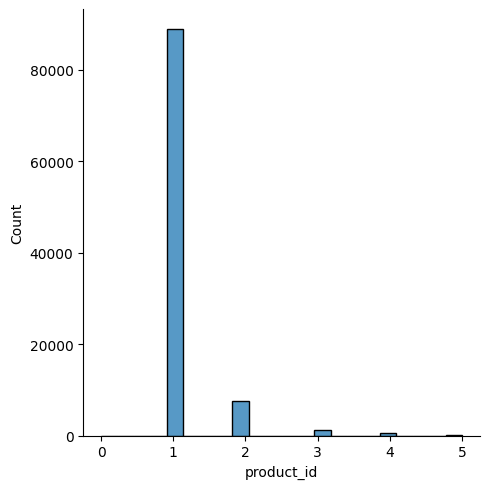

In [174]:
# Прибавилось подозрительно мало строк. Есть ощущение, что должно быть больше, ведь в одном заказе должно быть несколько product_id
# Смотрим распределение кол-ва product_id в одном заказе


product_ids_per_order = (order_items_table
                         .groupby(["order_id"], as_index=False) # группируем по order_id
                         .agg({"product_id": "count"}) # считаем кол-во товаров в заказе
                        )

sns.displot(data=product_ids_per_order, x="product_id", binrange=(0, 5))


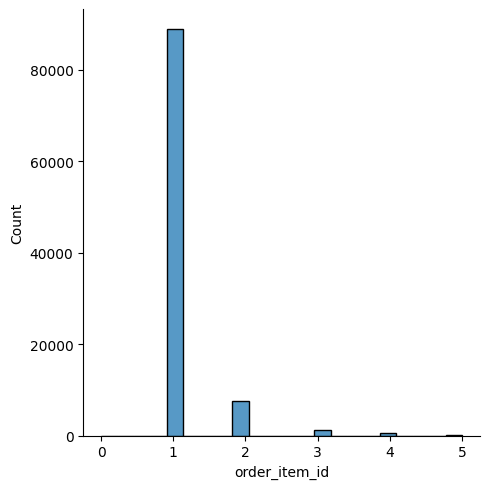

In [175]:
# На всякий случай рассчитываем распределение еще одним способом -- через максимальный order_item_id в заказе

another_product_count_per_order = order_items_table.groupby(
    ["order_id"], as_index=False # группируем по order_id
).agg({"order_item_id": "max"}) # выводим для каждого order_id максимальный порядковый номер товара в заказе

sns.displot(data=another_product_count_per_order, x="order_item_id", binrange=(0, 5))


In [176]:
# В подавляющем большинстве заказов действительно всего один товар, 
# так что кол-во прибавленных строк в новой таблице выглядит правдоподобным

In [177]:
# Добавляем в таблицу orders_table_w_items_data колонку с номером дня недели

orders_table_w_items_data["day_of_week"] = (
    orders_table_w_items_data.order_purchase_timestamp.dt.day_name() 
)


In [178]:
# Проверяем, что колонка создалась корректно


orders_table_w_items_data[["order_purchase_timestamp", "day_of_week"]]


,order_purchase_timestamp,day_of_week
0,2017-09-13 08:59:02,Wednesday
1,2017-04-26 10:53:06,Wednesday
2,2018-01-14 14:33:31,Sunday
3,2018-08-08 10:00:35,Wednesday
4,2017-02-04 13:57:51,Saturday
...,...,...
112645,2018-04-23 13:57:06,Monday
112646,2018-07-14 10:26:46,Saturday
112647,2017-10-23 17:07:56,Monday
112648,2017-08-14 23:02:59,Monday


In [179]:
# Делаем вычисления


most_selling_dow_by_product_id = (
    orders_table_w_items_data.groupby(["product_id", "day_of_week"], as_index=False) # группируем по id товара и дню недели
    .agg({"order_id": "nunique"}) # считаем кол-во уникальных заказов для каждого товара в каждый день недели 
    .rename(columns={"order_id": "order_count"})
    .sort_values(
        ["order_count"], ascending=False
    )  # сортируем весь df по убыванию кол-ва уник order_id
    .groupby(
        "product_id"
    )  # группируем по product_id, чтобы выбрать топовый день для каждого
    .head(1)  # выбираем первую строчку для каждого product_id; т.к. сортировка по убыванию кол-ва заказов,
) # это будет строчка c наибольшим их кол-вом для этого товара

most_selling_dow_by_product_id.head(10)


,product_id,day_of_week,order_count
36305,99a4788cb24856965c36a24e339b6058,Monday,87
40819,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,75
20009,53b36df67ebb7c41585e8d54d6772e08,Tuesday,70
49923,d1c427060a0f73f6b889a5c7c61f2ac4,Monday,60
15810,422879e10f46682990de24d770e7f83d,Thursday,58
19960,53759a2ecddad2bb87a079a1f1519f73,Wednesday,51
13456,389d119b48cf3043d311335e499d9c6b,Monday,49
12929,368c6c730842d78016ad823897a372db,Friday,49
14750,3dd2a17168ec895c781a9191c1e95ad7,Wednesday,49
10412,2b4609f8948be18874494203496bc318,Thursday,47


In [180]:
# Проверяем, правильно ли вывелся топ-1 день по продажам для каждого product_id

# Создаем таблицу со всеми днями для каждого product_id и сверяемся, 
# что на первую строчку попадает день с наибольшим кол-вом заказов

test_most_selling_dow_by_product_id = (
    orders_table_w_items_data.groupby(["product_id", "day_of_week"], as_index=False) 
    .agg({"order_id": "nunique"}) # считаем кол-во уникальных order_id
    .rename(columns={"order_id": "order_count"}) 
    .sort_values(["order_count", "product_id"], ascending=False) # сортируем по убыванию кол-во заказов и номера product_id
)

test_most_selling_dow_by_product_id.head(20)



,product_id,day_of_week,order_count
36305,99a4788cb24856965c36a24e339b6058,Monday,87
40819,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,75
36304,99a4788cb24856965c36a24e339b6058,Friday,74
36308,99a4788cb24856965c36a24e339b6058,Thursday,71
20009,53b36df67ebb7c41585e8d54d6772e08,Tuesday,70
40815,aca2eb7d00ea1a7b8ebd4e68314663af,Friday,69
40820,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,69
40816,aca2eb7d00ea1a7b8ebd4e68314663af,Monday,62
40821,aca2eb7d00ea1a7b8ebd4e68314663af,Wednesday,62
49923,d1c427060a0f73f6b889a5c7c61f2ac4,Monday,60


Вычисления корректны

#### **Результат анализа**

**Изначальная задача:**
По каждому товару определить, в какой день недели товар чаще всего покупается.

**Результат:**
В таблице ниже -- самый лучший день недели по кол-ву заказов для каждого product_id

In [181]:
most_selling_dow_by_product_id.head()

,product_id,day_of_week,order_count
36305,99a4788cb24856965c36a24e339b6058,Monday,87
40819,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,75
20009,53b36df67ebb7c41585e8d54d6772e08,Tuesday,70
49923,d1c427060a0f73f6b889a5c7c61f2ac4,Monday,60
15810,422879e10f46682990de24d770e7f83d,Thursday,58


In [182]:
# Сохраняем таблицу в excel-файл

most_selling_dow_by_product_id.to_excel('most_selling_dow_by_product_id.xlsx')

### Задача 1.4 Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 
Не стоит забывать, что внутри месяца может быть не целое количество недель. <br>
Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.


In [183]:
# Смотрим распределение кол-ва покупок по дням недели. Проверяем, есть ли смещение в пользу начала или конца недели.

# Считаем кол-во неотмененных покупок по дням недели

orders_count_throughout_week_days = (
    paid_non_canceled_orders.groupby( # группируем по дню недели создания заказа
        paid_non_canceled_orders.order_purchase_timestamp.dt.day_name()
    )
    .agg({"order_id": "count"}) # считаем кол-во заказов по дням недели
    .reset_index() # сбрасываем индекс для корректного отображения
)
orders_count_throughout_week_days


,order_purchase_timestamp,order_id
0,Friday,14046
1,Monday,16080
2,Saturday,10816
3,Sunday,11891
4,Thursday,14659
5,Tuesday,15849
6,Wednesday,15456


<Axes: xlabel='order_purchase_timestamp', ylabel='order_id'>

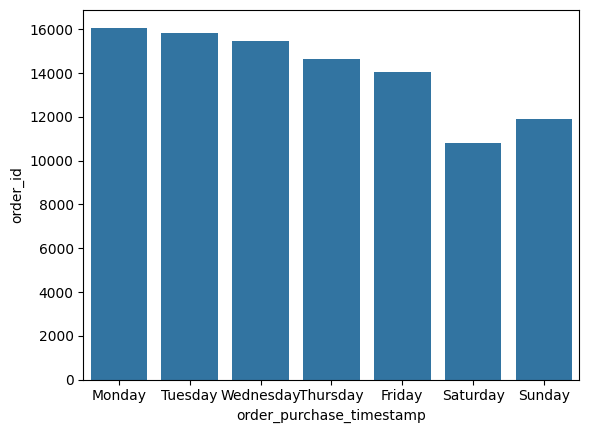

In [184]:
# Выводим кол-во покупок по дням на график для наглядности

sns.barplot(
    data=orders_count_throughout_week_days,
    x="order_purchase_timestamp",
    y="order_id",
    order=[ # кастомный порядок бинов для дней недели
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ],
)


Как видно, кол-во покупок имеет умеренный пик в начале недели и падает ближе к концу <br>
Из этого кажется логичным относить неделю к тому месяцу, где она началась.

In [185]:
# Подготавливаем данные для группировки по месяцу и неделе в году

# Добавляем колонку с первым днем недели для каждого дня в колонке order_purchase_timestamp

paid_non_canceled_orders["order_purchase_first_dow"] = ( # переводим время создания заказа в тип периода с частотой недели
    paid_non_canceled_orders["order_purchase_timestamp"].dt.to_period("W").dt.start_time
) # берем начало недели


In [186]:
# Создаем колонки для недели года и месяца года

paid_non_canceled_orders["order_purchase_cal_week_rounded"] = (
    paid_non_canceled_orders.order_purchase_first_dow.dt.isocalendar().week
)
paid_non_canceled_orders["order_purchase_month_rounded"] = (
    paid_non_canceled_orders.order_purchase_first_dow.dt.month
)


In [187]:
# Выделяем строки, где значение месяца в оригинальной колонке различается со значением месяца в новой колоне order_purchase_month_rounded

test_round_week_cols = paid_non_canceled_orders[
    paid_non_canceled_orders.order_purchase_timestamp.dt.month
    != paid_non_canceled_orders.order_purchase_month_rounded
]


In [188]:
# Печатаем выделенные колонки и проверяемы, что значение месяца различается, дополнительно сверяясь по датам

test_round_week_cols[
    [
        "order_purchase_timestamp",
        "order_purchase_first_dow",
        "order_purchase_cal_week_rounded",
        "order_purchase_month_rounded",
    ]
]


,order_purchase_timestamp,order_purchase_first_dow,order_purchase_cal_week_rounded,order_purchase_month_rounded
14,2018-03-01 14:14:28,2018-02-26,9,2
22,2018-02-03 20:37:35,2018-01-29,5,1
28,2018-05-02 11:45:38,2018-04-30,18,4
33,2018-02-03 12:38:58,2018-01-29,5,1
38,2018-06-01 12:23:13,2018-05-28,22,5
...,...,...,...,...
99410,2017-09-03 20:52:34,2017-08-28,35,8
99413,2018-04-01 16:13:26,2018-03-26,13,3
99416,2018-06-03 18:44:31,2018-05-28,22,5
99429,2017-11-05 16:17:53,2017-10-30,44,10


In [189]:
# Вычисляем среднее недельное кол-во покупок по месяцам у каждого пользователя

# Подготавливаемп промежуточную таблицу: уник_клиент | месяц | неделя_года | кол-во покупок

avg_weekly_purchase_count_by_user_and_month_test = (
    paid_non_canceled_orders.groupby(
        [ # группируем по:
            "customer_unique_id", # уникальному id пользователя
            "order_purchase_month_rounded", # месяцу, где началась неделя, когда произошла покупка
            "order_purchase_cal_week_rounded", # номеру недели в году, когда произошла покупка
        ],
        as_index=False,
    )
    .agg({"order_id": "count"}) # считаем кол-во заказов
    .sort_values(
        ["order_id", "customer_unique_id", "order_purchase_month_rounded"],
        ascending=False,
    )
)

# Проверяем структуру данных и логику группировки и аггрегации в промежуточной таблице
# Должна быть такая структура:
# уникальный_юзер
#     месяц (созданный на основе первого дня недели, в которой произошла покупка)
#         неделя_года (созданная на основе первого дня недели, в которой произошла покупка)
#             кол-во покупкок (order_id)

# Печатаем промежуточную таблицу на примере customer_unique_id с большим кол-вом заказов

(
    avg_weekly_purchase_count_by_user_and_month_test.query( # выводим заказы только одного юзера с большим кол-вом заказов
        'customer_unique_id == "8d50f5eadf50201ccdcedfb9e2ac8455"'
    ) 
    .sort_values("order_purchase_month_rounded") 
    .head(50)
)


,customer_unique_id,order_purchase_month_rounded,order_purchase_cal_week_rounded,order_id
53847,8d50f5eadf50201ccdcedfb9e2ac8455,5,21,2
53846,8d50f5eadf50201ccdcedfb9e2ac8455,5,20,1
53848,8d50f5eadf50201ccdcedfb9e2ac8455,6,24,1
53850,8d50f5eadf50201ccdcedfb9e2ac8455,7,29,2
53849,8d50f5eadf50201ccdcedfb9e2ac8455,7,27,1
53852,8d50f5eadf50201ccdcedfb9e2ac8455,7,31,1
53851,8d50f5eadf50201ccdcedfb9e2ac8455,7,30,2
53853,8d50f5eadf50201ccdcedfb9e2ac8455,8,32,1
53854,8d50f5eadf50201ccdcedfb9e2ac8455,8,33,1
53855,8d50f5eadf50201ccdcedfb9e2ac8455,8,34,1


Структура выглядит правильной. Делаем таблицу с финальной группировкой по customer_unique_id и месяцу

In [190]:
avg_weekly_purchase_count_by_user_and_month = ( 
    paid_non_canceled_orders.groupby(
        [ # группируем по:
            "customer_unique_id", # уникальному id пользователя
            "order_purchase_month_rounded", # месяцу, где началась неделя, когда произошла покупка
            "order_purchase_cal_week_rounded", # номеру недели в году, когда произошла покупка
        ],
        as_index=False,
    )
    .agg({"order_id": "count"}) # считаем кол-во заказов
    .sort_values(
        ["order_id", "customer_unique_id", "order_purchase_month_rounded"],
        ascending=False,
    )
    .rename(columns={"order_id": "purchase_count"})
    .groupby(["customer_unique_id", "order_purchase_month_rounded"], as_index=False) # группируем по уник id юзера и №месяца
    .agg({"purchase_count": "mean"}) # считаем среднее недельное кол-во заказов для каждого юзера в каждом месяце
    .rename(
        columns={ # переименовываем колонки для правильного восприятия
            "order_purchase_month_rounded": "month-No", # номер месяца
            "purchase_count": "avg_weekly_purchase_count", # среднее кол-во покупок
        }
    )
    .sort_values('avg_weekly_purchase_count', ascending = False)    
)

avg_weekly_purchase_count_by_user_and_month.head()


,customer_unique_id,month-No,avg_weekly_purchase_count
7269,12f5d6e1cbf93dafd9dcc19095df0b3d,1,6.0
50277,83e7958a94bd7f74a9414d8782f87628,1,4.0
14379,25a560b9a6006157838aab1bdbd68624,4,4.0
68918,b4e4f24de1e8725b74e4a1f4975116ed,2,4.0
76259,c8460e4251689ba205045f3ea17884a1,8,4.0


In [191]:
# Проверяем корректность вычислений на примере customer_unique_id с большим кол-вом заказов

# Выводим финальную аггрегированную таблицу с одним пользователем (8d50f5eadf50201ccdcedfb9e2ac8455)
avg_weekly_purchase_count_by_user_and_month.query(
    'customer_unique_id == "8d50f5eadf50201ccdcedfb9e2ac8455"'
)


,customer_unique_id,month-No,avg_weekly_purchase_count
53661,8d50f5eadf50201ccdcedfb9e2ac8455,5,1.5
53663,8d50f5eadf50201ccdcedfb9e2ac8455,7,1.5
53662,8d50f5eadf50201ccdcedfb9e2ac8455,6,1.0
53664,8d50f5eadf50201ccdcedfb9e2ac8455,8,1.0
53665,8d50f5eadf50201ccdcedfb9e2ac8455,9,1.0
53666,8d50f5eadf50201ccdcedfb9e2ac8455,10,1.0
53667,8d50f5eadf50201ccdcedfb9e2ac8455,11,1.0


In [192]:
# Выводим данные по этому же пользователю из таблицы, где видно простое кол-во заказов по каждой неделе, 
# без аггрегации в среднее по месяцу

# Среднее order_id по каждой неделе должно быть равно avg_weekly_purchase_count из таблицы выше

avg_weekly_purchase_count_by_user_and_month_test.query(
    'customer_unique_id == "8d50f5eadf50201ccdcedfb9e2ac8455"'
)

,customer_unique_id,order_purchase_month_rounded,order_purchase_cal_week_rounded,order_id
53850,8d50f5eadf50201ccdcedfb9e2ac8455,7,29,2
53851,8d50f5eadf50201ccdcedfb9e2ac8455,7,30,2
53847,8d50f5eadf50201ccdcedfb9e2ac8455,5,21,2
53859,8d50f5eadf50201ccdcedfb9e2ac8455,11,47,1
53857,8d50f5eadf50201ccdcedfb9e2ac8455,10,42,1
53858,8d50f5eadf50201ccdcedfb9e2ac8455,10,43,1
53856,8d50f5eadf50201ccdcedfb9e2ac8455,9,36,1
53853,8d50f5eadf50201ccdcedfb9e2ac8455,8,32,1
53854,8d50f5eadf50201ccdcedfb9e2ac8455,8,33,1
53855,8d50f5eadf50201ccdcedfb9e2ac8455,8,34,1


Вычисления корректны

#### Результат анализа

**Изначальный вопрос:**
Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)

**Результат:**
В таблице ниже -- среднее кол-во покупок в неделю с разбивкой по месяцам

In [193]:
avg_weekly_purchase_count_by_user_and_month.head()

,customer_unique_id,month-No,avg_weekly_purchase_count
7269,12f5d6e1cbf93dafd9dcc19095df0b3d,1,6.0
50277,83e7958a94bd7f74a9414d8782f87628,1,4.0
14379,25a560b9a6006157838aab1bdbd68624,4,4.0
68918,b4e4f24de1e8725b74e4a1f4975116ed,2,4.0
76259,c8460e4251689ba205045f3ea17884a1,8,4.0


In [194]:
# Записываем таблицу в excel-файл

avg_weekly_purchase_count_by_user_and_month.to_excel('avg_weekly_purchase_count_by_user_and_month.xlsx')

## Задача 2. Когортный анализ retention
В период с января по декабрь найти когорту с самым высоким retention на 3-й месяц

In [195]:
# Делаем таблицу с совершенными покупками

paid_non_canceled_orders = order_facts_table_w_uniq_cids.query( 
    'order_approved_at.isna() == False & order_status != "canceled"' # неотменненые заказы, у которых в колонке order_approved_at есть время подтверждения оплаты 
).copy() # делаем эту таблицу как копию, чтобы избежать конфликтов в будущем

In [196]:
# Проверяем, что джоин произошел корректно

paid_non_canceled_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6


In [197]:
# Добавляем колонки для формирования когорт и колонок месяцев

# Время для формирования колонок будем брать из колонки order_purchase_timestamp -- то есть время создания заказа.

# Добавляем колонку с месяцем заказа

paid_non_canceled_orders["order_month"] = ( #
    paid_non_canceled_orders.order_purchase_timestamp.dt.to_period( 
        "M" 
    ).dt.to_timestamp() # округляем до месяца через period и превращаем обратно в timestamp
)


# Добавляем колонку с первым месяцем заказа -- это будет колонка для когорты

paid_non_canceled_orders["first_order_month"] = (
    paid_non_canceled_orders.groupby("customer_unique_id")[ # группируем по уникальному id юзера
        "order_purchase_timestamp"
    ]
    .transform("min") # вычисляем datetime первого заказа для каждого customer_unique_id и возвращаем значения обратно в df
    .dt.to_period("M") # округляем до месяца
    .dt.to_timestamp() # преобразовываем обратно в timestamp
)


In [198]:
# Проверяем, что колонки создались корректно

test = paid_non_canceled_orders.query(
    'customer_unique_id == "8d50f5eadf50201ccdcedfb9e2ac8455"'
).sort_values("order_purchase_timestamp", ascending=True)

test.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,order_month,first_order_month
68664,5d848f3d93a493c1c8955e018240e7ca,0e4fdc084a6b9329ed55d62dcd653ccf,shipped,2017-05-15 23:30:03,2017-05-15 23:42:34,2017-05-17 10:42:20,NaT,2017-05-26,8d50f5eadf50201ccdcedfb9e2ac8455,2017-05-01,2017-05-01
77205,369634708db140c5d2c4e365882c443a,b2b13de0770e06de50080fea77c459e6,delivered,2017-06-18 22:56:48,2017-06-18 23:10:19,2017-06-19 20:12:26,2017-06-23 12:55:50,2017-07-07,8d50f5eadf50201ccdcedfb9e2ac8455,2017-06-01,2017-05-01
16231,5837a2c844decae8a778657425f6d664,31dd055624c66f291578297a551a6cdf,unavailable,2017-07-17 22:11:13,2017-07-17 22:23:46,NaT,NaT,2017-08-17,8d50f5eadf50201ccdcedfb9e2ac8455,2017-07-01,2017-05-01
33703,4f62d593acae92cea3c5662c76122478,dfb941d6f7b02f57a44c3b7c3fefb44b,delivered,2017-07-18 23:10:58,2017-07-18 23:23:26,2017-07-20 19:00:02,2017-07-21 16:19:40,2017-07-31,8d50f5eadf50201ccdcedfb9e2ac8455,2017-07-01,2017-05-01
19127,bf92c69b7cc70f7fc2c37de43e366173,42dbc1ad9d560637c9c4c1533746f86d,delivered,2017-07-24 22:11:50,2017-07-24 22:25:14,2017-07-26 01:42:03,2017-07-31 16:59:58,2017-08-15,8d50f5eadf50201ccdcedfb9e2ac8455,2017-07-01,2017-05-01


In [199]:
# Делаем подготовительную таблицу для когортного анализа
# Дальше ее будем приводить в нужный вид через pivot
cohort_analysis_prep = (paid_non_canceled_orders
                       .groupby(['first_order_month', 'order_month'], as_index = False) # группируем по месяцу когорты и по месяцу реактивации
                       .agg({'customer_unique_id':'nunique'}) # считаем кол-во уникальный юзеров
                       .sort_values(['first_order_month','order_month']) 
                       .rename(columns = {'customer_unique_id':'customers_count'})
                       
                       )

cohort_analysis_prep.tail(10) # печатаем последние строки получившейся таблицы, т.к. они более наглядные, чем первые строки

,first_order_month,order_month,customers_count
210,2018-05-01,2018-06-01,34
211,2018-05-01,2018-07-01,17
212,2018-05-01,2018-08-01,13
213,2018-06-01,2018-06-01,5923
214,2018-06-01,2018-07-01,25
215,2018-06-01,2018-08-01,16
216,2018-07-01,2018-07-01,6034
217,2018-07-01,2018-08-01,31
218,2018-08-01,2018-08-01,6215
219,2018-08-01,2018-09-01,1


In [200]:
# Создаем колонку с порядковым номером месяца реактивации для каждой когорты
# Эта колонка будет нужна для корректного отображения месяцев реактивации в финальной таблице

cohort_analysis_prep["cohort_period"] = \
( 
cohort_analysis_prep.order_month.dt.to_period("M" ).astype("int") # превращаем значения order_month в Period и дальше в Int
- cohort_analysis_prep.first_order_month.dt.to_period("M").astype("int") # делаем то же с first_order_month и считаем разницу
)


In [201]:
# Проверяем, что колонка создалась правильно

# Печатаем таблицу с новой колонкой cohort_period. 
# В ней должна быть корректная разница между first_order_month и order_month 
cohort_analysis_prep.sort_values(['first_order_month','cohort_period']).head() 

,first_order_month,order_month,customers_count,cohort_period
0,2016-09-01,2016-09-01,2,0
1,2016-10-01,2016-10-01,297,0
2,2016-10-01,2017-04-01,1,6
3,2016-10-01,2017-07-01,1,9
4,2016-10-01,2017-09-01,1,11


In [202]:
# Вычисляем retention в новой колонке
# Для этого делим кол-во уникальных пользователей в каждом месяце реактивации на кол-во уникальных пользователей в day 0

cohort_analysis_prep["retention_percent"] = (
    cohort_analysis_prep["customers_count"] # кол-во уникальных пользователей
    / cohort_analysis_prep.groupby(["first_order_month"])["customers_count"].transform( # с помощью transform делаем подобие оконной функции
        "max" # максимально кол-во уник. пользователей для каждой когорты, то есть кол-во пользователей day 0
    )
) * 100 # умножаем на 100, чтобы в дальнейшем привести в форму процента

cohort_analysis_prep.head()


,first_order_month,order_month,customers_count,cohort_period,retention_percent
0,2016-09-01,2016-09-01,2,0,100.0000
1,2016-10-01,2016-10-01,297,0,100.0000
2,2016-10-01,2017-04-01,1,6,0.3367
3,2016-10-01,2017-07-01,1,9,0.3367
4,2016-10-01,2017-09-01,1,11,0.3367


In [203]:
# Выбираем данные только за 2017 год
cohort_analysis_prep_2017 = (cohort_analysis_prep
                            .query('first_order_month.dt.year == 2017 & order_month.dt.year == 2017')
                            .copy() 
                            )

# Проверяем, что данные отфлильтровались корректно
cohort_analysis_prep_2017.head()

,first_order_month,order_month,customers_count,cohort_period,retention_percent
12,2017-01-01,2017-01-01,760,0,100.000000
13,2017-01-01,2017-02-01,3,1,0.394737
14,2017-01-01,2017-03-01,2,2,0.263158
15,2017-01-01,2017-04-01,1,3,0.131579
16,2017-01-01,2017-05-01,3,4,0.394737


In [204]:
# Округялем колонку с месяцем когорты для лучшей читаемости
cohort_analysis_prep_2017['first_order_month'] = cohort_analysis_prep['first_order_month'].dt.strftime('%Y-%m')

In [205]:
# Проверяем финальную подготовительную табличку

cohort_analysis_prep_2017.sort_values(['first_order_month','order_month']).head()

,first_order_month,order_month,customers_count,cohort_period,retention_percent
12,2017-01,2017-01-01,760,0,100.000000
13,2017-01,2017-02-01,3,1,0.394737
14,2017-01,2017-03-01,2,2,0.263158
15,2017-01,2017-04-01,1,3,0.131579
16,2017-01,2017-05-01,3,4,0.394737


In [206]:
# Приводим данные в формат когортной таблицы с помощью pivot


retention_cohort_table = cohort_analysis_prep_2017.pivot(
    index="first_order_month", columns="cohort_period", values="retention_percent"
)

retention_cohort_table


cohort_period,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-01,100.0,0.394737,0.263158,0.131579,0.394737,0.131579,0.526316,0.131579,0.131579,NaN,0.394737,0.131579
2017-02,100.0,0.232153,0.290192,0.116077,0.406268,0.116077,0.232153,0.174115,0.116077,0.232153,0.116077,NaN
2017-03,100.0,0.499424,0.345755,0.384172,0.345755,0.153669,0.153669,0.307338,0.345755,0.076834,NaN,NaN
2017-04,100.0,0.599829,0.214225,0.171380,0.299914,0.257069,0.342759,0.299914,0.299914,NaN,NaN,NaN
2017-05,100.0,0.476057,0.504060,0.392047,0.308037,0.336040,0.420050,0.168020,NaN,NaN,NaN,NaN
2017-06,100.0,0.447857,0.351887,0.415867,0.255918,0.383877,0.351887,NaN,NaN,NaN,NaN,NaN
2017-07,100.0,0.517063,0.336091,0.258532,0.284385,0.206825,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,100.0,0.672753,0.336377,0.264296,0.360404,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,100.0,0.680934,0.535019,0.291829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [207]:
# Применяем стили для лучшей читаемости


retention_cohort_table_final = (retention_cohort_table
            .style 
            .set_caption('User retention by cohort')  # добавляем подпись\
            .background_gradient(cmap='cividis')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2f}%", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту


retention_cohort_table_final

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-01,100.00%,0.39%,0.26%,0.13%,0.39%,0.13%,0.53%,0.13%,0.13%,,0.39%,0.13%
2017-02,100.00%,0.23%,0.29%,0.12%,0.41%,0.12%,0.23%,0.17%,0.12%,0.23%,0.12%,
2017-03,100.00%,0.50%,0.35%,0.38%,0.35%,0.15%,0.15%,0.31%,0.35%,0.08%,,
2017-04,100.00%,0.60%,0.21%,0.17%,0.30%,0.26%,0.34%,0.30%,0.30%,,,
2017-05,100.00%,0.48%,0.50%,0.39%,0.31%,0.34%,0.42%,0.17%,,,,
2017-06,100.00%,0.45%,0.35%,0.42%,0.26%,0.38%,0.35%,,,,,
2017-07,100.00%,0.52%,0.34%,0.26%,0.28%,0.21%,,,,,,
2017-08,100.00%,0.67%,0.34%,0.26%,0.36%,,,,,,,
2017-09,100.00%,0.68%,0.54%,0.29%,,,,,,,,


#### Результат анализа:
Самый высокий retention на третий месяц
Если считать с момента первой активности пользователей, то самый высокий retention на третий месяц у когорты 2017-09
Если считать с первого полного месяца, то самый высокий retention на третий месяц -- у когорты 2017-06


## Задача 3
В этой задаче нам нужно будет провести RFM-сегментацию и сделать выводы по получившемуся соотношению сегментов.<br>
При RFM-сегментации пользователи делятся по сегментац в зависимости от их показателей: <br>
- Recency (недавность?) -- насколько давно пользователь совершал покупку в последний раз
- Frequency (частота) -- как часто пользователь делал покупки. Иначе говоря, кол-во заказов за изучаемый период.
- Monetary (денежность) -- как много пользователь потратил на покупки за изучаемый период

In [208]:
# Создаем таблицу с суммой цен товаров в заказах, чтобы позже вычислить показатель Monetary

order_totals = (
    order_items_table
    .groupby(["order_id"], as_index=False)
    .agg({"price": "sum"})
    .sort_values(["price"], ascending=False)
)

order_totals.head()


,order_id,price
1455,03caa2c082116e1d31e67e9ae3700499,13440.0
44467,736e1922ae60d0d6a89247b851902527,7160.0
3130,0812eb902a67711a1cb742b3cdaa65ae,6735.0
98298,fefacc66af859508bf1a7934eab1e97f,6729.0
94439,f5136e38d1a14a4dbd87dff67da82701,6499.0


In [209]:
# Проверяем, что цены товаров просуммировались корректно


order_items_table.query('order_id == "03caa2c082116e1d31e67e9ae3700499"')["price"].sum()


np.float64(13440.0)

Результат: Цены товаров просуммировались корректно

In [210]:
# Делаем source-таблицу, из которой будем брать данные для анализа
# Для этого к таблице order_facts_table_w_uniq_cids джоиним таблицу order_totals и убираем отмененные и неоплаченные заказы


orders_data_for_rfm = pd.merge(
    left=order_facts_table_w_uniq_cids, right=order_totals, how="right", on="order_id"
    # мерджим по order_totals, потому что нас интересует только те заказы, у которых есть данные по товарам
).query(
    'order_status != "unavailable" & order_status != "canceled" & order_approved_at.isna() == False'
)  # убираем unavailable и canceled заказы, а также те, где нет времени подтверждения оплаты


In [211]:
# Визуально проверяем структуру данных в финальной таблице на корректность
orders_data_for_rfm.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,price
0,03caa2c082116e1d31e67e9ae3700499,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29 15:24:52,2017-10-02 15:28:20,2017-10-10 15:43:17,2017-10-17 18:22:29,2017-10-23,0a0a92112bd4c708ca5fde585afaa872,13440.0
1,736e1922ae60d0d6a89247b851902527,ec5b2ba62e574342386871631fafd3fc,delivered,2018-07-15 14:49:44,2018-07-17 04:31:36,2018-07-20 13:09:00,2018-07-26 22:03:06,2018-08-02,763c8b1c9c68a0229c42c9fc6f662b93,7160.0
2,0812eb902a67711a1cb742b3cdaa65ae,c6e2731c5b391845f6800c97401a43a9,delivered,2017-02-12 20:37:36,2017-02-12 20:45:12,2017-02-16 09:23:13,2017-03-03 14:23:18,2017-03-09,dc4802a71eae9be1dd28f5d788ceb526,6735.0
3,fefacc66af859508bf1a7934eab1e97f,f48d464a0baaea338cb25f816991ab1f,delivered,2018-07-25 18:10:17,2018-07-27 04:05:13,2018-08-03 14:42:00,2018-08-15 14:57:50,2018-08-10,459bef486812aa25204be022145caa62,6729.0
4,f5136e38d1a14a4dbd87dff67da82701,3fd6777bbce08a352fddd04e4a7cc8f6,delivered,2017-05-24 18:14:34,2017-05-26 02:45:17,2017-05-26 11:20:47,2017-06-05 17:09:48,2017-06-28,ff4159b92c40ebe40454e3e6a7c35ed6,6499.0


In [212]:
# Проверяем, что в финальной таблице нет отмененных и unavailable заказов


orders_data_for_rfm['order_status'].value_counts() # смотрим, какие статусы заказов есть в таблице


order_status
delivered     96464
shipped        1106
invoiced        312
processing      301
approved          2
Name: count, dtype: int64

Результат: отмененных и unavailable заказов нет

In [213]:
# Проверяем, что в таблице нет неоплаченных заказов


orders_data_for_rfm.query('order_approved_at.isna() == True') # Ищем заказы без времени подтверждения оплаты 



,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,price


Результат: неоплаченных заказов нет

In [214]:
# Проверяем, что у всех заказов есть стоимость (price)


orders_data_for_rfm.query('price.isna() == True')



,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,price


Результат: заказов без стоимости нет

In [215]:
# Берем из таблицы-источника только те колонки, которые нужны для анализа -- так будет удобнее работать
# Выделяем выбранные колонки в отдельную таблицу


subset_orders_data_for_rfm = orders_data_for_rfm[
    ["order_id", "customer_unique_id", "order_purchase_timestamp", "price"]
].copy()

subset_orders_data_for_rfm.head()


,order_id,customer_unique_id,order_purchase_timestamp,price
0,03caa2c082116e1d31e67e9ae3700499,0a0a92112bd4c708ca5fde585afaa872,2017-09-29 15:24:52,13440.0
1,736e1922ae60d0d6a89247b851902527,763c8b1c9c68a0229c42c9fc6f662b93,2018-07-15 14:49:44,7160.0
2,0812eb902a67711a1cb742b3cdaa65ae,dc4802a71eae9be1dd28f5d788ceb526,2017-02-12 20:37:36,6735.0
3,fefacc66af859508bf1a7934eab1e97f,459bef486812aa25204be022145caa62,2018-07-25 18:10:17,6729.0
4,f5136e38d1a14a4dbd87dff67da82701,ff4159b92c40ebe40454e3e6a7c35ed6,2017-05-24 18:14:34,6499.0


In [216]:
# Смотрим, какой период времени охватывает таблица


print(subset_orders_data_for_rfm["order_purchase_timestamp"].min())
print(subset_orders_data_for_rfm["order_purchase_timestamp"].max())

print(
    subset_orders_data_for_rfm["order_purchase_timestamp"].max()
    - subset_orders_data_for_rfm["order_purchase_timestamp"].min()
)


2016-09-04 21:15:19
2018-09-03 09:06:57
728 days 11:51:38


Для анализа будем брать данные за последние 365 дней, по двум причинам:
- как правило, для RFM-анализа берется период от 6 до 12 месяцев
- для нас более ценными являются данные о более свежих покупках и пользователях

In [217]:
# Задаем период времени для анализа в формате int кол-ва дней (365)
# Его будем использовать, чтобы брать в анализ определенное кол-во дней
# Записываем его в переменную, чтобы при необходимости заменить значение и быстро пересчитать анализ для другого периода

period = 365

Задаем "текущую" дату. Она понадобится, чтобы:
- отмерить период времени для выборки данных для анализа
- оценить параметр recency (насколько недавно совершена покупка)

In [218]:
# Задаем дату NOW -- один день после самого последнего дня покупки в таблице-источнике

NOW = (
    (subset_orders_data_for_rfm["order_purchase_timestamp"].max() + timedelta(days=1)) # + 1 день к дню последней покупки
    .to_period("D") # чтобы округлить до дня, переводим в период
    .to_timestamp() # и переиводим обратно в timestamp
)

# Проверяем текущую дату

print(NOW)


2018-09-04 00:00:00


In [219]:
# Задаем дату начала периода для анализа.

# Для этого из текущей даты вычитаем период времени для анализа
start_of_period = NOW - timedelta(days = period)

print(start_of_period)

2017-09-04 00:00:00


In [220]:
print(type(start_of_period))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [221]:
# Выделяем из таблицы-источника данные за нужный период (последние 365 дней)

rfm_data_final_subset = (subset_orders_data_for_rfm
                    .query('order_purchase_timestamp.between(@start_of_period, @NOW)') # задаем дату между start_of_period и NOW
                    .sort_values('order_purchase_timestamp') # сортируем возрастанию даты создания заказа 
                   )


# Проверяем первые и последние строки новой таблицы
rfm_data_final_subset

# Период времени выглядит корректным

,order_id,customer_unique_id,order_purchase_timestamp,price
44479,40943871fddded9badd0c7a30758807c,8156e9b793de0ff0faf06bb7cd6d3078,2017-09-04 00:48:49,97.99
35645,79ecc3e68b2d54e056223964de8bca98,7011c18021a7ba540f53349a324677ed,2017-09-04 01:18:42,118.33
4300,549eaa78237c5a5c9ca1cc4a8d812208,e9465ca5e9043493c69b786fcb10619e,2017-09-04 04:19:30,449.00
50524,41a207671f292d00ffea01b171f2a30b,1ce1097b476f97ea37d805251c5c74ba,2017-09-04 05:00:16,84.00
45827,5504a1a5092b8696eac00711644d4306,d7fb410ce33db84828fa62bca8bfc654,2017-09-04 08:08:29,92.89
...,...,...,...,...
4683,0b223d92c27432930dfe407c6aea3041,5c58de6fb80e93396e2f35642666b693,2018-08-29 14:18:23,418.00
74085,168626408cb32af0ffaf76711caae1dc,7febafa06d9d8f232a900a2937f04338,2018-08-29 14:18:28,45.90
89736,03ef5dedbe7492bdae72eec50764c43f,b701bebbdf478f5500348f03aff62121,2018-08-29 14:52:00,24.90
49898,35a972d7f8436f405b56e36add1a7140,24ac2b4327e25baf39f2119e4228976a,2018-08-29 15:00:37,84.99


**Начинаем вычислять параметры Recency, Frequency и Monetary:**<br>
- Recency -- насколько недавно пользователь делал покупку. Вычисляется как количество дней с последней покупки
- Frequency -- насколько часто пользователь делал покупки за изучаемый период. Вычисляется как кол-во покупок за период
- Monetary -- как много пользователь тратил на покупки за изучаемые период. Вычисляется как сумма цен товаров во всех заказах за период

In [222]:
# Для вычисления Recency нам понадобится кол-во дней, прошедших с заказа до текущего момента

# Вычитаем дату создания каждого заказа из текущей даты (NOW) и преобразуем в int кол-во дней

rfm_data_final_subset["days_since_order"] = rfm_data_final_subset[
    "order_purchase_timestamp"
].apply(lambda x: (NOW - x).days)

rfm_data_final_subset.head()


,order_id,customer_unique_id,order_purchase_timestamp,price,days_since_order
44479,40943871fddded9badd0c7a30758807c,8156e9b793de0ff0faf06bb7cd6d3078,2017-09-04 00:48:49,97.99,364
35645,79ecc3e68b2d54e056223964de8bca98,7011c18021a7ba540f53349a324677ed,2017-09-04 01:18:42,118.33,364
4300,549eaa78237c5a5c9ca1cc4a8d812208,e9465ca5e9043493c69b786fcb10619e,2017-09-04 04:19:30,449.00,364
50524,41a207671f292d00ffea01b171f2a30b,1ce1097b476f97ea37d805251c5c74ba,2017-09-04 05:00:16,84.00,364
45827,5504a1a5092b8696eac00711644d4306,d7fb410ce33db84828fa62bca8bfc654,2017-09-04 08:08:29,92.89,364


**Вычисляем Recency, Frequency и Monetary и записываем в соответствующие колонки**

In [223]:
# Создаем аггрегирующие функции для создания колонок Recency, Frequency и Monetary 
# Закидываем функции в словарь, чтобы применить через df.agg()

aggr = {
    'days_since_order': 'min',  # кол-во дней, прошедших с самого свежего заказа пользователя до NOW -- Recency
    'order_id': 'count', # кол-во заказов, сделанных пользователем за изучаемый период -- Frequency
    'price': 'sum' # сумма чеков всех заказов, сделанных за изучаемый период -- Monetary 
}

# Применяем функции
rfm = (rfm_data_final_subset
       .groupby('customer_unique_id', as_index = False) # группируем по уникальному id пользователя
       .agg(aggr) # применяем функции аггрегации, которые создали выше
      )


rfm.rename(
    columns={
        "days_since_order": "Recency",
        "order_id": "Frequency",
        "price": "Monetary",
    },
    inplace=True,
)

In [224]:
# Выводим на печать таблицу с новыми колонками Recency, Frequency и Monetary
rfm.sort_values(["Frequency"], ascending=False).head()


,customer_unique_id,Recency,Frequency,Monetary
40136,8d50f5eadf50201ccdcedfb9e2ac8455,14,11,440.94
17771,3e43e6105506432c953e165fb2acf44c,188,9,1000.85
28613,6469f99c1f9dfae7733b25662e7f1782,67,7,664.20
7779,1b6c7548a2a1f9037c1fd3ddfed95f33,201,7,809.21
57768,ca77025e7201e3b30c44b472ff346268,94,7,806.61


Проверяем, что колонки Recency, Frequency и Monetary посчитались правильно

In [225]:
# Проверяем колонку Recency

test_r = rfm_data_final_subset.query(
    'customer_unique_id == "8d50f5eadf50201ccdcedfb9e2ac8455"'
)["days_since_order"].min()

test_r


np.int64(14)

Результат: колонка Recency посчиталась правильно

In [226]:
# Проверяем колонку Frequency

test_f = rfm_data_final_subset.query(
    'customer_unique_id == "8d50f5eadf50201ccdcedfb9e2ac8455"'
)["order_id"].count()

test_f


np.int64(11)

Результат: колонка Frequency посчиталась правильно

In [227]:
# Проверяем колонку Monetary

test_m = rfm_data_final_subset.query(
    'customer_unique_id == "8d50f5eadf50201ccdcedfb9e2ac8455"'
)["price"].sum()

test_m


np.float64(440.93999999999994)

Результат: колонка Monetary посчиталась правильно

Все колонки RFM создались корректно


#### **Переходим к назначению оценок R, F и M**

Назначить оценки RFM можно несколькими способами. Вот два наиболее простых в исполнении:

1. С помощью квантилей
Берем несколько квантилей (обычно 2-4) с равными промежутками между собой. Например, 0.2, 0.4, 0.6, 0.8 или 0.33, 0.66. 
Значения квантилей будут выступать границами интервалов. Дальше значения попадают в один из интервалов и получают оценку

2. С помощью кастомных интервалов
Здесь логика та же, что и квантилями, но границы интервалов мы задаем сами.

Чтобы принять решение, какой способ использовать, нужно изучить распределение Recency, Frequency и Monetary

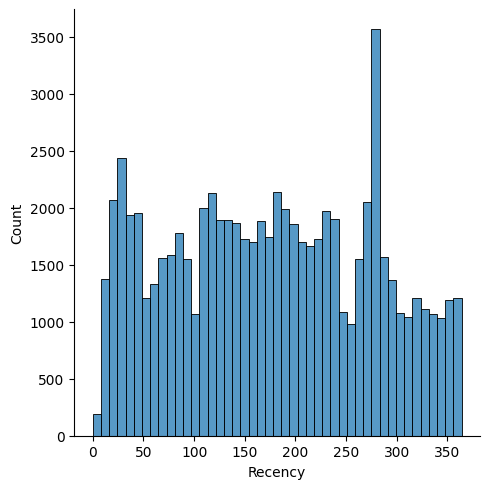

In [228]:
# Смотрим распределение Recency

sns.displot(data = rfm, x = 'Recency')

# За исключением пика в районе 280 дней, данные распределены достаточно равномерно
# Для Recency можно использовать назначение оценки R через квантили

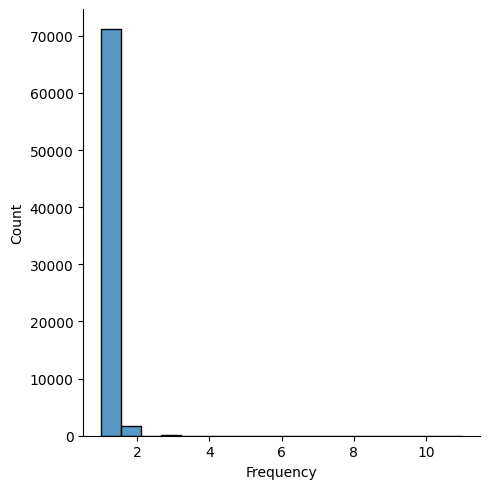

In [229]:
# Смотрим распределение Frequency (кол-во заказов пользователя за период)
sns.displot(data = rfm, x = 'Frequency', binrange=(1, 11))

# Видим, что распределение очень сильно смещено в сторону 1 заказа

In [230]:
# Смотрим распределение Frequency в цифрах

rfm['Frequency'].value_counts()

Frequency
1     71129
2      1706
3        96
4        16
5         5
7         3
9         1
11        1
Name: count, dtype: int64

Распределение Frequency показывает, что у нас есть 4 сегмента пользователей:
1. One-time buyer              -- 1 покупка  -- покупают один раз за год. Таких -- подавляющее большинство
2. Occasional repeat customers -- 2 покупки  -- изредка возвращаются за второй покупкой
3. Лояльные клиенты            -- 3 покупки  -- покупают 3 раза в год; таких -- чуть меньше сотни
4. Супер лояльные              -- 4+ покупки -- покупают часто, но таких -- единицы

Учитывая смещенность распределения, в случае Frequency лучше будет определить кастомные интервалы для оценок.<br>

Также, стандартная система с пятью оценками здесь не подойдет: получатся слишком маленькие сегменты с F=4 и F=5 <br>
В качестве альтернативы можно использовать 4-х бальную и 3-х бальную систему. <br>
Какую выбрать -- зависит от распределения остальных параметров -- Recency и Monetary



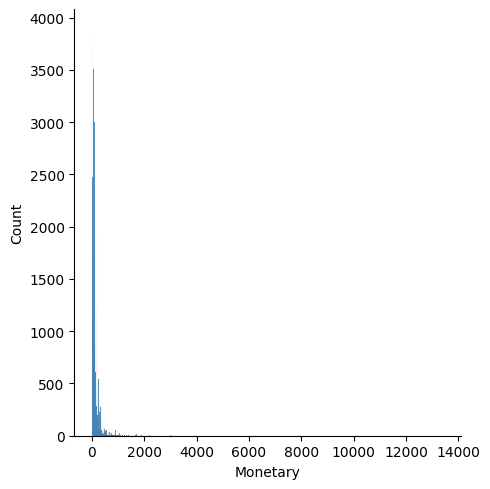

In [231]:
# Смотрим распределение Monetary

sns.displot(data = rfm, x = 'Monetary')



На первый взгляд распределение выгляд смещенным к маленьким значениям Monetary. <br>
Это может быть из-за экстремально высоких значений Monetary, которые растягивают ось x и сужают пик

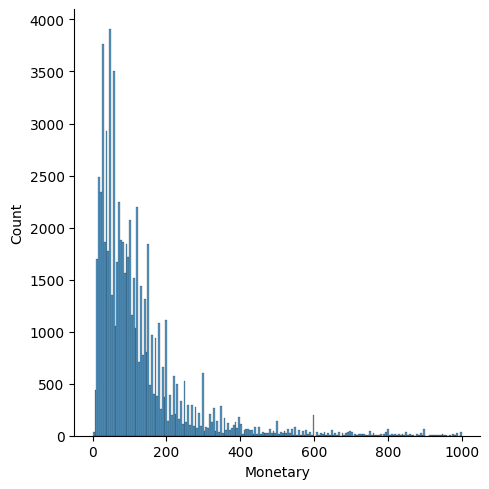

In [232]:
# Смотрим распределение без экстремально высоких значений Monetary


m_outliers = rfm["Monetary"].quantile(
    q=0.99
)  # Берем значение значение 99-го перцентиля в качестве верхней границы

rfm_m_score_w_less_outliers = rfm.query(
    "Monetary.between(0, @m_outliers)"
)  # Берем данные, где Frequency между 0 и q=0.99

sns.displot(
    data=rfm_m_score_w_less_outliers, x="Monetary"
)  # строим график распределения

# Распределение все еще смещено в сторону меньших значений Monetary, но такие данные в любом случае уже
# можно делить с помощью квантилей


Вывод по выбору системы бальности оценок RFM

Судя по графикам:
1. Recency имеет относительно ровное распределение, за исключением пика в районе 280 дней
2. Frequency имеет экстремально сильное смещение в пользу единоразовых покупок
и при этом имеет очень малое кол-во очень клиентов с очень частыми покупками.
3. Monetary также имеет довольно сильное смещение в сторону меньших сумм денег,
и при этом есть небольшое кол-во пользователей, тратящих крупные суммы.

Исходя из этого четырехбальная система выглядит более подходящей, по двум причинам:
- Наличие 4-го балла позволяет выделить самых лояльных клиентов с самыми большими тратами в отдельный сегмент.
В этом она лучше трехбальной системы, которую трудно натянуть на такое распределение.
- Сегмент самых лояльных и самых "денежных" юзеров становится немного шире. 
Их не пара человек, как было бы при 5 баллах, а пара десятков. Такое кол-во юзеров
имеет больше смысла в реальном применении сегментов для маркетинговых активностей.

##### **Назначаем оценки RFM**

Создаем таблицу с квантилями значений Recency и Monetary <br>
С этими квантилями будем сравнивать значения Recency и Frequency каждого юзера, чтобы назначить оценки R и M

In [233]:
# Берем квантили 0.25, 0.5, 0.75 значений Recency и Monetary

quartiles = (
    rfm[["Recency", "Monetary"]]  # берем значений Recency и Monetary
    .quantile([0.25, 0.5, 0.75])  # указываем квантили, которе нужно вывести
    .to_dict()  # переводим в словарь, чтобы было удобнее обращаться к значениям квантилей
)

quartiles


{'Recency': {0.25: 92.0, 0.5: 175.0, 0.75: 263.0},
 'Monetary': {0.25: 47.9, 0.5: 89.88999999999999, 0.75: 152.25}}

Пишем функции для назначения оценки
Оценка будет назначаться в зависимости от попадания Recency и Frequency в тот или иной интервал

In [234]:


# Пишем функцию для Recency
# Чем ниже Recency, тем выше оценка

def r_score(x):
    if x <= quartiles['Recency'][0.25]: # обращаемся к значению Recency с ключом 0.25 и сравниваем 
        return 4
    elif x <= quartiles['Recency'][0.5]: # делаем то же самое с остальными квантилями
        return 3
    elif x <= quartiles['Recency'][0.75]: 
        return 2
    else:
        return 1

    
# Пишем функцию для Monetary
# Чем выше Monetary, тем выше оценка

def m_score(x):
    if x <= quartiles['Monetary'][0.25]: # обращаемся к значению Monetary с ключом 0.25 и сравниваем 
        return 1
    elif x <= quartiles['Monetary'][0.5]: # делаем то же самое с остальными квантилями
        return 2
    elif x <= quartiles['Monetary'][0.75]:
        return 3
    elif x > quartiles['Monetary'][0.75]:
        return 4



Теперь пишем функцию для назначения оценок Frequency
Здесь мы будем назначать границы интервалов для оценок на свое усмотрение

In [235]:
# Еще раз смотрим распределение клиентов по кол-ву заказов
rfm['Frequency'].value_counts()





Frequency
1     71129
2      1706
3        96
4        16
5         5
7         3
9         1
11        1
Name: count, dtype: int64

В распределении можно выделить 4 основных кластера:
1. One-time buyers             -- 1 покупка 
2. Периодечески возвращающиеся -- 2 покупки
3. Лояльные клиенты            -- 3 покупки
4. Супер лояльные              -- 4+ покупки

In [236]:
# На основе этих интервалов пишем функцию для назначения оценок Frequency


def f_score(x):
    if x == 1:
        return 1
    elif x == 2:
        return 2
    elif x == 3:
        return 3
    else:
        return 4


In [237]:
# Назначаем оценки Recency, Frequency и Monetary с помощью написанных функций


rfm["R"] = rfm["Recency"].apply(lambda x: r_score(x))    # назначаем оценку R
rfm["F"] = rfm["Frequency"].apply(lambda x: f_score(x))  # назначаем оценку F
rfm["M"] = rfm["Monetary"].apply(lambda x: m_score(x))   # назначаем оценку M


Сравниваем оценки RFM со значениями Recency, Frequency и Monetary
Проверяем, что оченки назначились корректно

In [238]:
print(rfm.sort_values(["Frequency"], ascending=False).head())
print(rfm.sort_values(["Frequency"], ascending=False).tail())

# Вывод: оценки назначились корректно


                     customer_unique_id  Recency  Frequency  Monetary  R  F  M
40136  8d50f5eadf50201ccdcedfb9e2ac8455       14         11    440.94  4  4  4
17771  3e43e6105506432c953e165fb2acf44c      188          9   1000.85  2  4  4
28613  6469f99c1f9dfae7733b25662e7f1782       67          7    664.20  4  4  4
7779   1b6c7548a2a1f9037c1fd3ddfed95f33      201          7    809.21  2  4  4
57768  ca77025e7201e3b30c44b472ff346268       94          7    806.61  3  4  4
                     customer_unique_id  Recency  Frequency  Monetary  R  F  M
72936  ffe9e41fbd14db4a7361347c56af5447      204          1    199.00  2  1  4
72937  ffeb904468642a1ce663a322629801cb       68          1     77.50  4  1  2
72938  ffec10ad4229ba46818560e1c8b40a68      151          1    120.00  3  1  3
72939  ffec490ab531184a483efe2eedd68908       31          1     39.90  4  1  1
5      00050ab1314c0e55a6ca13cf7181fecf      136          1     27.99  3  1  1


In [239]:
# Создаем колонку с значением RFM-сегмента для каждого пользователя

rfm["RFM_segment"] = (
    rfm["R"].astype("str") + 
    rfm["F"].astype("str") + 
    rfm["M"].astype("str")
)

# Проверяем, что колонка создалась правильно

rfm.head()


,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_segment
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,3,1,3,313
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,3,1,1,311
2,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,1,1,1,111
3,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,1,1,4,114
4,0004bd2a26a76fe21f786e4fbd80607f,151,1,154.00,3,1,4,314


Переходим к назначению RFM-сегментов на основе оценок RFM <br>
Перед назначением сегментов, лучше сначала посмотреть на распределения оценок

Это нужно по двум причинам:
1. У нас четырехбальная система оценок, где по определению нет середины. Чтобы корректно
назначить сегменты, нужно будет смотреть, какое кол-во юзеров имеют ту или иную оценку RFM
2. Как мы уже знаем, значение Frequency сильно смещено в сторону 1 заказа. Нужно изучить, 
как это отражается на распределении M

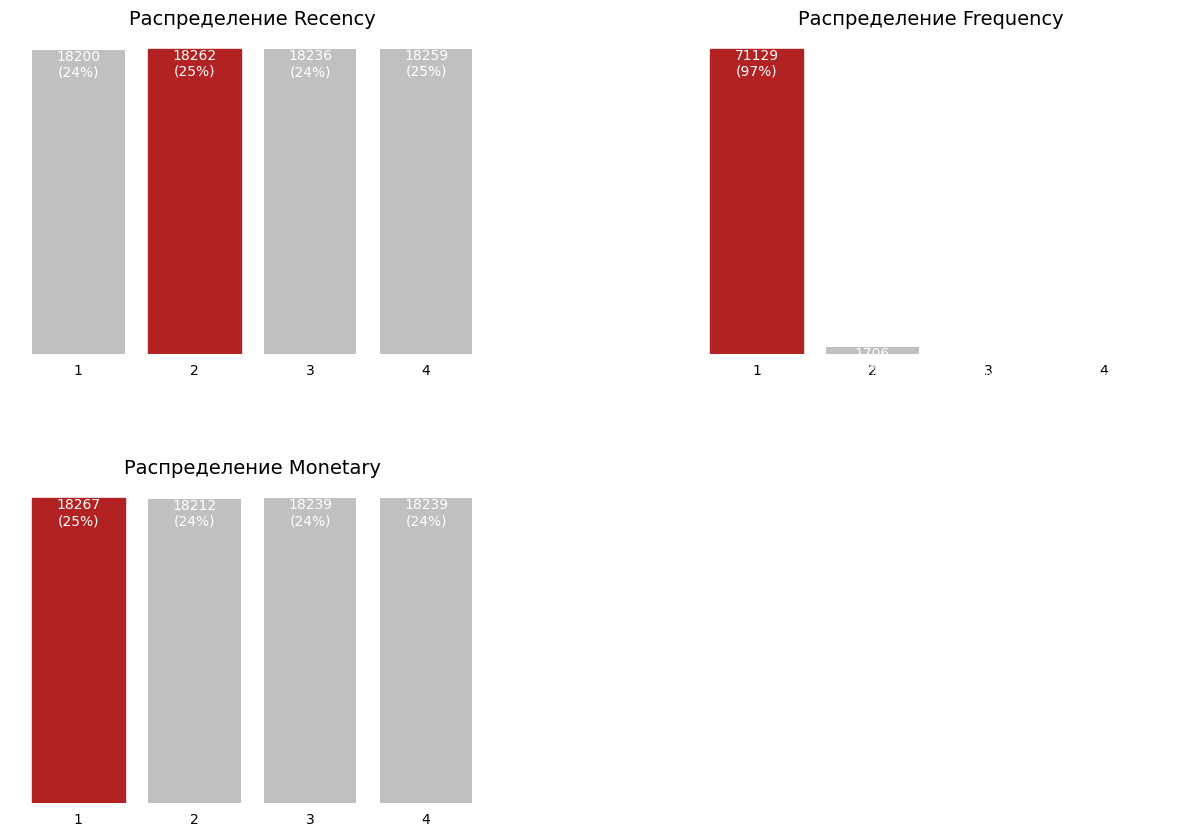

In [240]:
# Изучаем распределения Recency, Frequency и Monetary

# Строим графики распределения значений Recency, Frequency и Monetary

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

for i, p in enumerate(["R", "F", "M"]):
    parameters = {"R": "Recency", "F": "Frequency", "M": "Monetary"}
    y = rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i // 2, i % 2]
    bars = ax.bar(x, y, color="silver")
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title("Распределение {}".format(parameters[p]), fontsize=14)

    # Устанавливаем тики в пределах 4 баллов для лучшей читаемости

    ax.set_xticks([1, 2, 3, 4])
    ax.set_xticklabels([1, 2, 3, 4])

    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color("firebrick")
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            value - 5,
            "{}\n({}%)".format(int(value), int(value * 100 / y.sum())),
            ha="center",
            va="top",
            color="w",
        )
# Убираем неотрисованный четвертый график, чтобы не мешался

fig.delaxes(axes[1, 1])

plt.subplots_adjust(
    hspace=0.4, wspace=0.4
)  # Делаем больше места между графиками для лучшей читаемости
plt.show()


Распределение Monetary выглядит подозрительно ровным <br>
Проверяем, действительно ли количество юзеров с разными оценками настолько похоже

In [241]:
# Создаем словарь с значениями квантилей 0.25, 0.5, 0.75

m_q = rfm["Monetary"].quantile([0.25, 0.5, 0.75]).to_dict()

m_q


{0.25: 47.9, 0.5: 89.88999999999999, 0.75: 152.25}

In [242]:
# Считаем кол-во юзеров, которые попали в каждый интервал между квантилями
# Иначе говоря, считаем кол-во юзеров с каждой из оценок

m_q_0to25 = rfm.query('Monetary <= @m_q[0.25]').shape[0] # юзеры с оценкой M=1
m_q_26to50 = rfm.query('Monetary > @m_q[0.25] & Monetary <= @m_q[0.5]').shape[0] # юзеры с оценкой M=2
m_q_51to75 = rfm.query('Monetary > @m_q[0.50] & Monetary <= @m_q[0.75]').shape[0] # юзеры с оценкой M=3
m_q_75to100 = rfm.query('Monetary > @m_q[0.75]').shape[0] # юзеры с оценкой M=4

print(f"Кол-во юзеров с оценкой M = 1 -- {m_q_0to25}")
print(f"Кол-во юзеров с оценкой M = 2 -- {m_q_26to50}")
print(f"Кол-во юзеров с оценкой M = 3 -- {m_q_51to75}")
print(f"Кол-во юзеров с оценкой M = 4 -- {m_q_75to100}")

Кол-во юзеров с оценкой M = 1 -- 18267
Кол-во юзеров с оценкой M = 2 -- 18212
Кол-во юзеров с оценкой M = 3 -- 18239
Кол-во юзеров с оценкой M = 4 -- 18239


**Вывод по распределению оценок M**:<br>
Видим, что ошибок в назначении оценок нет. Распределение оценок Monetary действительно настолько ровное

Теперь посмотрим, как зависит Оценка Monetary от оценок R и M <br>
Так мы сможем понять, наскольк сумма трат зависит от частоты и свежести заказа

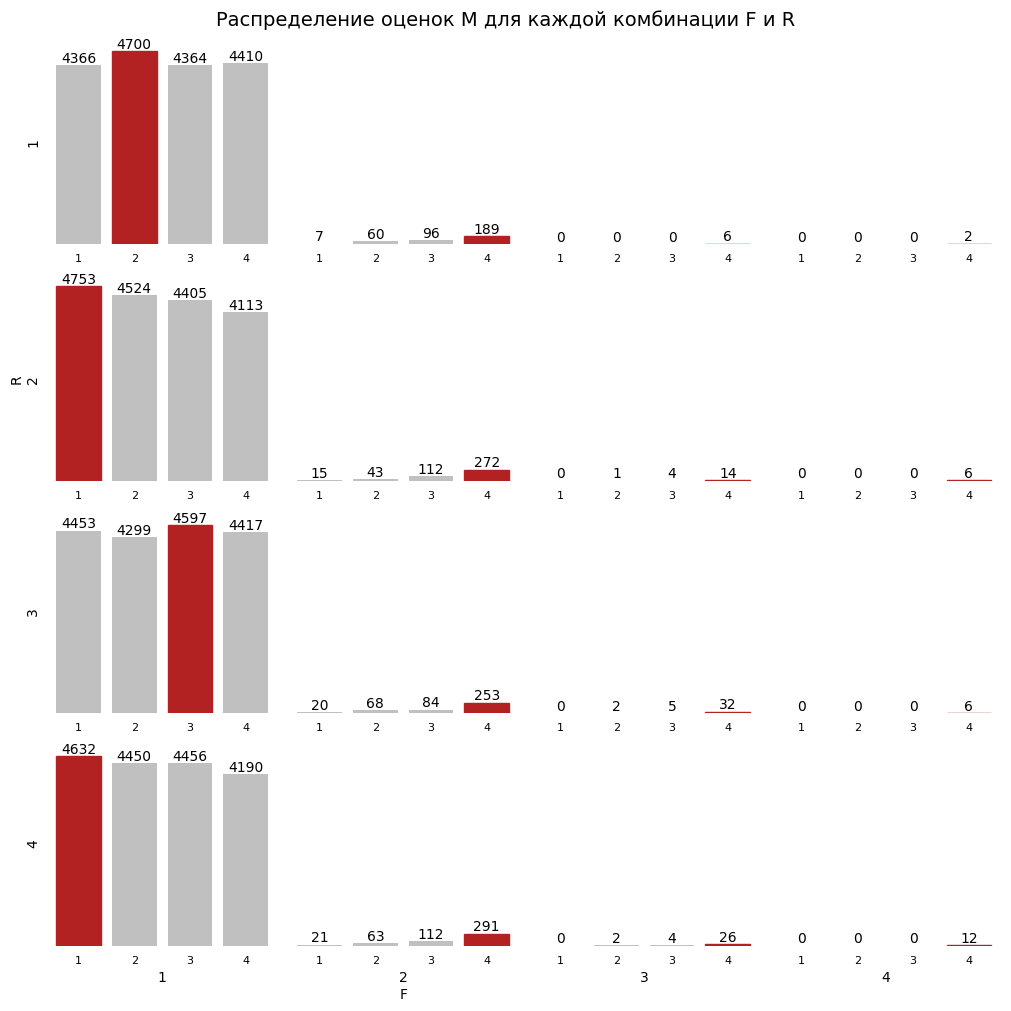

In [243]:
# Делаем график распределения оценок Monetary для каждой комбинаици R и M
# На нем будем видно, как много тратят юзеры, которые покупают часто или редко, недавно или давно


fig, axes = plt.subplots(nrows=4, ncols=4,
                         sharex=False, sharey=True,
                         figsize=(10, 10),
                         constrained_layout=True) # указываем constrained_layout = True, 
#                                                   чтобы заголовок не наезжал на сами графики

r_range = range(1, 5)
f_range = range(1, 5)
for r in r_range:
    for f in f_range:
        y = rfm[(rfm['R'] == r) & (rfm['F'] == f)]['M'].value_counts().sort_index()
        x = np.arange(1, rfm['M'].max() + 1)  # Делаем так, чтобы в каждом графике был столбце для каждый оценки
        y = y.reindex(x, fill_value=0)  # Заполняем нулем пустые значения 
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 4:
            if f == 2:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 2:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')

# Добавляем заголовок
fig.suptitle('Распределение оценок M для каждой комбинации F и R', fontsize=14)

plt.show()


Видим, что между оценками F и M есть зависимость. Чем выше частота заказов (F), тем больше общие суммы заказов (M) <br>
Другими словами, юзеры с наибольшей частотой заказов -- это наши самые "денежные" юзеры.<br>

Это хорошо видно при F = 4, где мы видим только юзеров с наибольшими тратами (M = 4)<br>

Определяем сегменты на основании оценок RFM

Мы будем использовать классические 10 сегментов
Границы R и M для некоторых могут немного отличаться от классических. При определении сегментов, мы не можем 
слишком часто использовать интервалы F (F = 2-3, 1-2 и т.д) из-за очень неровного распределения F. Поэтому,
чтобы сделать сегменты более различными друг от друга, нужно будет немного смещать границы R и M.

Дальше описаны RFM-сегменты, на которые будем делить пользователей:
Для каждого сегмента указно: 
- определение
- общие оценки в формате Low/Medium/High R/F/M
- Точные оценки в нашем случае в формате R = 1, F = 1, M = 1


1. Champions
   - Определение: Самые лучшие клиенты. Покупают чаще всех и больше всех.
   - Общие оценки RFM: High Recency (R), High Frequency (F), High Monetary (M)
   - Точные оценки RFM: R = 4, F = 4, M = 4

2. Лояльные клиенты
   - Определение: Клиенты, которые покупают регулярно. Они довольны товарами, ценами и сервисом.
   - Общие оценки RFMs: High Recency (R), Medium to High Frequency (F), Medium to High Monetary (M)
   - Точные оценки: R = 4, F = 2-3, M = 3-4

3. Потенциально лояльные клиенты
   - Определение: Эти клиенты делали покупки недавно, но пока что они не очень частые и не очень крупные.
   - Общие оценки RFMs: High Recency (R), Medium Frequency (F), Medium Monetary (M)
   - Точные оценки: R = 4, F = 2, M = 2

4. Новые клиенты
   - Определение: Эти клиенты недавно сделали свою первую покупку. Делают покупки небольших размеров
   - Общие оценки RFMs: High Recency (R), Low Frequency (F), Low to Medium Monetary (M)
   - Точные оценки: R = 4, F = 1, M = 1-2

5. Перспективные клиенты
   - Определение: Эти клиенты делали покупки средних и крупных размеров недавно, но еще не покупают часто.
   - Общие оценки RFMs: High Recency (R), Low to Medium Frequency (F), Medium to High Monetary (M)
   - Точные оценки: R = 3-4, F = 1, M = 3-4

6. Требуется внимание
   - Определение: Эти клиенты покупали достаточно часто на средние/большие суммы, но не покупают в последнее время.
   - Общие оценки RFMs: Medium Recency (R), Medium Frequency (F), Medium Monetary (M)
   - Точные оценки: R = 2-3, F = 2, M = 2-3

7. Скоро уснут
   - Определение: Эти клиенты довольно давно не покупали и скоро могут стать неактивными.
   - Общие оценки RFMs: Low to Medium Recency (R), Low to Medium Frequency (F), Medium Monetary (M)
   - Точные оценки: R = 1-2, F = 1, M = 2

8. В зоне риска
   - Определение: Эти клиенты раньше часто делали крупные покупки, но уже давно не возвращаются. Могут стать окончательно неактивными.
   - Общие оценки RFMs: Low Recency (R), Medium to High Frequency (F), Medium to High Monetary (M)
   - Точные оценки: R = 1, F = 2-3, M = 3

9. Нельзя терять
    - Определение: Это самые "денежные" клиенты, которые давно не делали покупки. Их критически важно вернуть.
    - Общие оценки RFMs: Low Recency (R), Medium to High Frequency (F), High Monetary (M)
    - Точные оценки: R = 1, F = 3-4, M = 4

10. В спячке
    - Определение: Низкая активность по всем параметрам. Самые неактивные клиенты.
    - Общие оценки RFMs: Low Recency (R), Low Frequency (F), Low Monetary (M)
    - Точные оценки: R = 1, F = 1, M = 1


Создаем механизм назначения сегментов в зависимости от оценок RFM

In [244]:
# Сначала создаем словарь в формате {'оценки R/F/M' : 'название RFM-сегмента'}
# Этот словарь будем использовать замены комбинации R/F/M на соответствующий сегмент

segt_map = {
    r'444':'Чемпионы',
    r'4[2-3][3-4]':'Лояльные клиенты',
    r'422':'Потенциально лояльные',
    r'41[1-2]':'Новые клиенты',
    r'[3-4]1[3-4]':'Перспективные клиенты',
    r'[2-3]2[2-3]':'Требуется внимание',
    r'[1-2]12':'Скоро уснут',
    r'1[2-3][3]':'В зоне риска',
    r'1[3-4][3-4]':'Нельзя терять',
    r'111':'В спячке'
}

rfm['Segment'] = rfm['RFM_segment'] # создаем копию столбца RFM_segment
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True) # Заменяем оценки RFM на соответствующие

rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_segment,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,3,1,3,313,Перспективные клиенты
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,3,1,1,311,311
2,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,1,1,1,111,В спячке
3,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,1,1,4,114,114
4,0004bd2a26a76fe21f786e4fbd80607f,151,1,154.00,3,1,4,314,Перспективные клиенты


Видим, что некоторые RFM-сегменты нее попали в финальную десятку сегментов и не получили названия.
Это ожидаемо, т.к из 64 возможных сегментов, мы написали условия только для 10.

In [245]:
# Смотрим, сколько RFM-сегментов осталось без имени


segments_wo_labels = rfm.query("Segment == RFM_segment")
segments_wo_labels.shape[0]




31706

~32 тысяч клиентов не попавших в десятку главных сегментов -- это довольно много. <br>
Почти половина от всех ~73к клиентов. Нужно изучить эти сегменты подробнее

Смотрим  сегментов, не попавших в десятку главных

In [246]:
segments_wo_labels_counts = segments_wo_labels["Segment"].value_counts()  # считаем кол-во клиентов у каждого сегмента
segments_wo_labels_counts.reset_index().rename( # сбрасываем индекс и переименовываем колонки
    columns={"index": "RFM_segment", "Segment": "customers_count"}
)




,customers_count,count
0,211,4753
1,311,4453
2,114,4410
3,213,4405
4,113,4364
5,312,4299
6,214,4113
7,224,272
8,324,253
9,124,189


Видим, что подавляющее число сегментов, не попавших в десятку, объединяет один признак -- F = 1.
То есть, это сегменты тех, кто покупает скорее редко, и таких -- подавляющее большинство в нашем распределении Frequency.

Определить имена для этих сегментов можно несколькими способами:
- Расширить или вообще пересмотреть границы главных десяти сегментов
- Добавить еще сегментов, куда бы могли подойти эти
- Получить больше данных о метриках пользователей (CLV и др.) и создать сегменты с учетом их влияния

Однако, текущее решение с десятью основными сегментами -- общепринятый формат, поэтому в текущей итерации
лучше будем придерживаться его.

Расширять или пересматривать границы сегментов также не стоит. Большинство "неопределившихся" сегментов -- либо
"середнячки", либо малоактивные пользователи. Специально тянуть их в соседние сегменты -- значит нарушать границы
главных сегментов, которые и без того трудно выстроить корректно из-за смещенного распределения Frequency.

Кажется, что лучшее решение -- получить ОС по текущему варианту сегментации и при необходимости расширить анализ,
добавив данные по другим метрикам (CLV и др.). С помощью других метрик мы сможем сделать более видимыми различия
между разными сегментами с F = 1.

Делаем таблицу только с клиентами, которые попали в десятку основных сегментов <br>
Ее мы будем использовать в финальном анализе

In [247]:
rfm_labeled_segments_only = rfm.query(
    "Segment != RFM_segment"
)  # Segment не равен RFM_segment

rfm_labeled_segments_only.head()


,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_segment,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,3,1,3,313,Перспективные клиенты
2,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,1,1,1,111,В спячке
4,0004bd2a26a76fe21f786e4fbd80607f,151,1,154.00,3,1,4,314,Перспективные клиенты
7,0005ef4cd20d2893f0d9fbd94d3c0d97,175,1,104.90,3,1,3,313,Перспективные клиенты
8,00082cbe03e478190aadbea78542e933,288,1,79.00,1,1,2,112,Скоро уснут


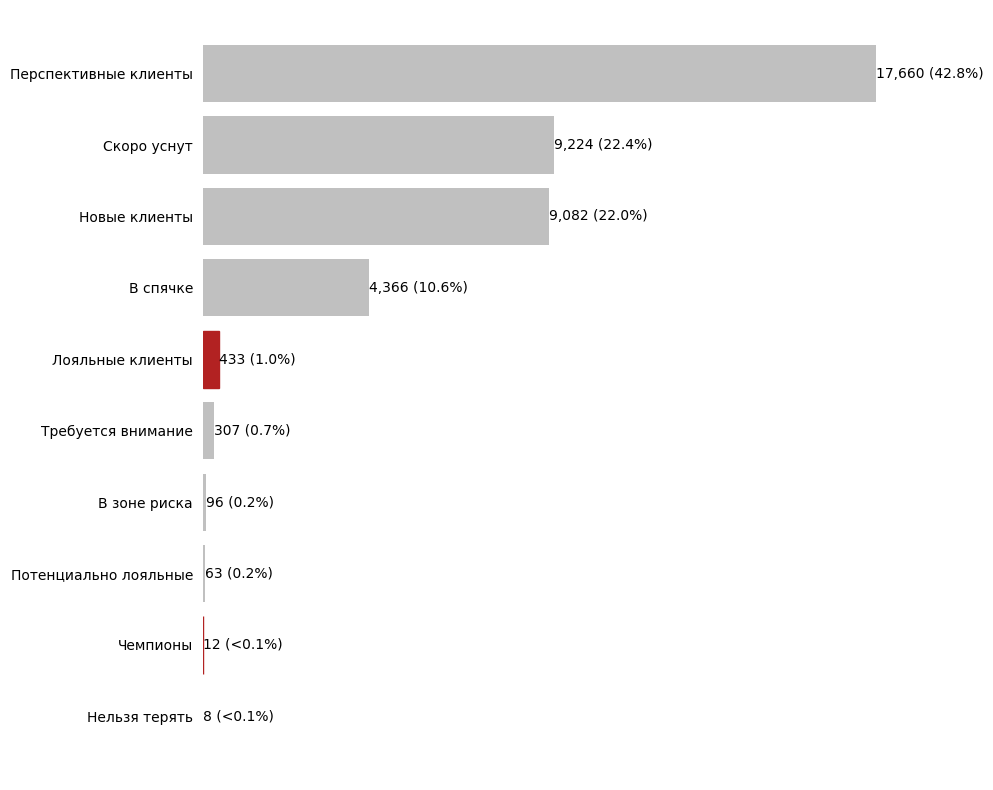

In [248]:
# Выводим график с количеством пользователей в каждом из десяти основных сегментов

# Считаем кол-во клиентов в каждом сегменте
segments_counts = rfm_labeled_segments_only['Segment'].value_counts().sort_values(ascending=True)

# Создаем figure и axes. Задаем размер побольше, чтобы хорошо поместились все сегменты
fig, ax = plt.subplots(figsize=(10, 8))

# Создаем горизонтальный барчарт
bars = ax.barh(range(len(segments_counts)), segments_counts, color='silver')

# Убираем фон и оси
ax.set_frame_on(False)
ax.tick_params(left=False, bottom=False, labelbottom=False)

# Задаем шкалу y-оси и лейблы баров
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index, ha='right')  # Rotate labels

# Подствечиваем ключевые сегменты пользователей
for i, bar in enumerate(bars):
    value = bar.get_width()
    if segments_counts.index[i] in ['Чемпионы', 'Лояльные клиенты']:
        bar.set_color('firebrick')
    
    # Указываем, чтобы отражались проценты только >= 0.1% для лучше читаемости
    percentage = value * 100 / segments_counts.sum()
    if percentage < 0.1:
        display_percentage = '<0.1%'
    else:
        display_percentage = '{:.1f}%'.format(percentage)
        
    ax.text(value,
            bar.get_y() + bar.get_height() / 2,
            '{:,} ({})'.format(int(value), display_percentage),
            va='center',
            ha='left')

plt.tight_layout()

# Show plot
plt.show()



### РЕЗУЛЬТАТЫ АНАЛИЗА RFM-сегментов:

**Выводы по распределению RFM-сегментов:**

1. Довольно мало лояльных клиентов -- всего около одного процента, во всяком случае, в текущем довольно строгом
определении лояльных клиентов. 

2. Чемпионов еще меньше -- меньше 0.1%. Это также может быть связано с довольно строгими RFM-границами этого сегмента.

3. Достаточно много Перспективных клиентов -- 42%. Они покупали недавно, на крупные и очень крупные суммы, но пока 
не покупают достаточно часто. С помощью подходящих маркетинговых активностей их можно стимулировать покупать чаще.
Усли получится повысить частоту заказов у даже маленький части Перспективных клиентов, это принесет существенный эффект
за счет их большого количества.

4. Есть существенная доля количество почти спящих клиентов -- 22.4%. Это не самые денежные клиенты, но их доля довольно 
высока. # На этот сегмент стоит как минимум обратить внимание.

5. Из других "засыпающих" сегментов, стоит обратить внимание на сегметы "В зоне риска" и "Нельзя терять"
В них всего по 96 и 8 клиентов соответственно, но они покупали часто и на крупные суммы. Их окончательная
потеря будет ощутима.


## Резюмируем результаты анализа

**Задача 1.1**

**Изначальный вопрос:**
Сколько у нас пользователей, которые совершили покупку только один раз?


In [249]:
print(f"""Результат анализа:
У нас {one_purchasers_count} пользователей, которые совершили покупку только один раз""")

Результат анализа:
У нас 92621 пользователей, которые совершили покупку только один раз


**Задача 1.2**

**Изначальный вопрос** <br>
Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)

**Ответ:** <br>
В таблице ниже -- среднее кол-во заказов в месяц с разбивкой по причинам.
Также эта таблица сохранена в excel-файл 'avg_non_delivered_orders_count_by_non_delivery_reason'


In [250]:
avg_non_delivered_orders_count_by_non_delivery_reason

,non_delivery_reason,avg_monthly_orders_count
0,shipping_issue,48.43
1,order_products_unavailable,27.67
2,order_canceled_before_shipping,19.81
3,order_not_processed,16.90
4,sld_not_met_by_seller,3.38
5,order_canceled_after_shipping,3.29
6,order_unavailable_reason_uknknown,0.33
7,order_not_started,0.14
8,reason_unknown,0.05


**Легенда по статусам недоставленных заказов:**

1. shipping_issue -- Заказ отправлен и не доставлен. Что-то случилось в пути
2. order_products_unavailable -- Возможно, продуктов не оказалось в наличии, поэтому заказ не был собран и отправлен
3. order_canceled_before_shipping -- заказ отменен пользоваетем до отправки
4. order_not_processed -- заказ не собран
5. sld_not_met_by_seller -- Заказ отправле и не доставлен, при этом продавец не передал его вовремя в службу логистики
6. order_canceled_after_shipping -- заказ отменен после отправки
7. order_unavailable_reason_uknknown - заказ недоступен, при этом товары в нем доступны
8. order_not_started -- заказ был оплачен, но так и не был начат

**Задача 1.3**

**Изначальная задача:**
По каждому товару определить, в какой день недели товар чаще всего покупается.

**Результат:**
Таблица с лучшим днем недели для каждого заказа сохранена в excel-файл 'most_selling_dow_by_product_id

**Задача 1.4**

**Изначальный вопрос:**
Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)

**Результат:**
Таблица с средним недельным кол-вом покупок для каждого юзера записана в excel-файл 'avg_weekly_purchase_count_by_user_and_month.xlsx'

**Задача 2**

**Изначальный вопрос:**
У какой когорты самый высокий retention на 3-й месяц с период с января по декабрь

**Результат:** <br>
Самый высокий retention на третий месяц <br>
Если считать с момента первой активности пользователей, то самый высокий retention на третий месяц у когорты 2017-09 <br>
Если считать с первого полного месяца, то самый высокий retention на третий месяц -- у когорты 2017-06<br>

Ниже -- таблица когортного анализа retention за 2017 год

In [251]:
retention_cohort_table_final

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-01,100.00%,0.39%,0.26%,0.13%,0.39%,0.13%,0.53%,0.13%,0.13%,,0.39%,0.13%
2017-02,100.00%,0.23%,0.29%,0.12%,0.41%,0.12%,0.23%,0.17%,0.12%,0.23%,0.12%,
2017-03,100.00%,0.50%,0.35%,0.38%,0.35%,0.15%,0.15%,0.31%,0.35%,0.08%,,
2017-04,100.00%,0.60%,0.21%,0.17%,0.30%,0.26%,0.34%,0.30%,0.30%,,,
2017-05,100.00%,0.48%,0.50%,0.39%,0.31%,0.34%,0.42%,0.17%,,,,
2017-06,100.00%,0.45%,0.35%,0.42%,0.26%,0.38%,0.35%,,,,,
2017-07,100.00%,0.52%,0.34%,0.26%,0.28%,0.21%,,,,,,
2017-08,100.00%,0.67%,0.34%,0.26%,0.36%,,,,,,,
2017-09,100.00%,0.68%,0.54%,0.29%,,,,,,,,
